## 1.预处理

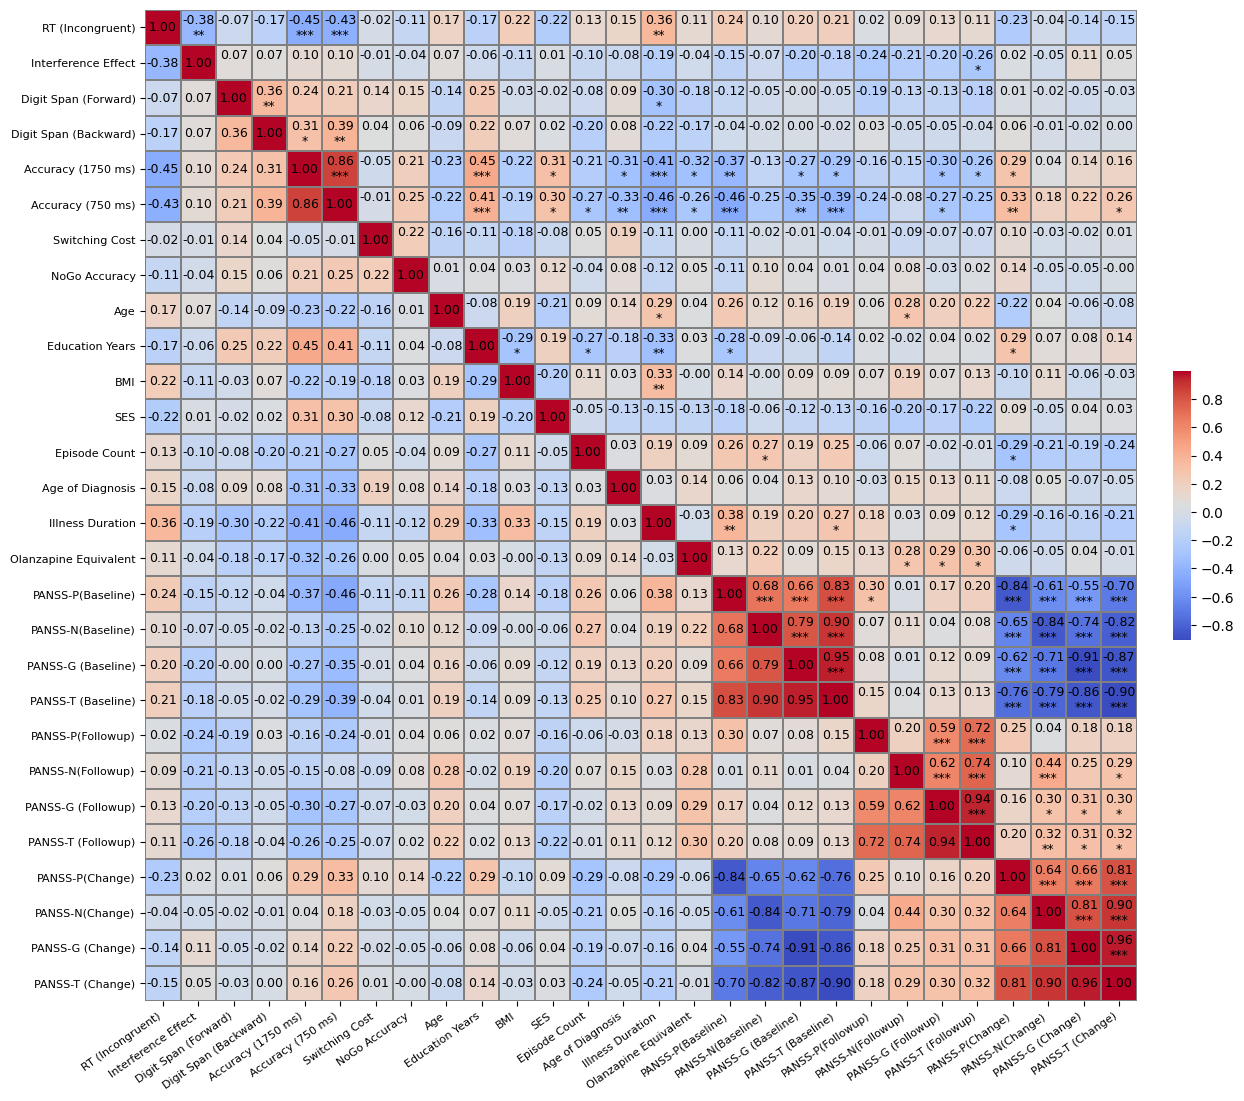

Correlation matrix with PANSS scores and change scores has been successfully generated!


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.multitest import multipletests
from scipy import stats

# 定义异常值检测和填充函数
def handle_outliers(series):
    mean = series.mean()
    std = series.std()
    lower_bound = mean - 3.5 * std
    upper_bound = mean + 3.5 * std
    series = series.clip(lower=lower_bound, upper=upper_bound)
    return series

# 读取 Excel 文件
file_name = 'rawdata.xlsx'
data = pd.read_excel(file_name)

# 缺失值填充为均值（对数值列）
data = data.fillna(data.select_dtypes(include=[np.number]).mean(numeric_only=True))

# 异常值处理（仅针对数值列）
for column in data.select_dtypes(include=['number']).columns:
    data[column] = handle_outliers(data[column])

# 字段名称更新为英文科研规范名称
column_mapping = {
    "ID": "ID",
    "不一致前测": "Incongruent_Pretest",
    "干扰效应前测": "Interference_Effect_Pretest",
    "不一致后测": "Incongruent_Posttest",
    "干扰效应后测": "Interference_Effect_Posttest",
    "正背前测": "Forward_Span_Pretest",
    "正背后测": "Forward_Span_Posttest",
    "数字倒背前测": "Backward_Span_Pretest",
    "数字倒背后测": "Backward_Span_Posttest",
    "1750前测": "1750ms_Pretest",
    "1750后测": "1750ms_Posttest",
    "750前测": "750ms_Pretest",
    "750后测": "750ms_Posttest",
    "转换代价前测": "Switching_Cost_Pretest",
    "转换代价后测": "Switching_Cost_Posttest",
    "nogoacc后测": "NoGo_Accuracy_Posttest",
    "nogoacc前测": "NoGo_Accuracy_Pretest",
    "Age": "Age",
    "Education years": "Education_Years",
    "BMI": "BMI",
    "SES": "SES",
    "Gender": "Gender",
    "Ethnic": "Ethnic",
    "Residence": "Residence",
    "Only child": "Only_Child",
    "Smoking status": "Smoking_Status",
    "Alcohol consumption": "Alcohol_Consumption",
    "Employed": "Employed",
    "Marital status": "Marital_Status",
    "name": "Name",
    "Group": "Group",
    "是否首发": "First_Episode",
    "发病次数": "Episode_Count",
    "确诊年龄": "Age_of_Diagnosis",
    "病程（年）": "Illness_Duration",
    "奥氮平当量（mg/day）": "Olanzapine_Equivalent",
    "PANSS-positive at baseline": "PANSS_Positive_Baseline",
    "PANSS-negative at baseline": "PANSS_Negative_Baseline",
    "PANSS -G at baseline": "PANSS_G_Baseline",
    "PANSS -T at baseline": "PANSS_T_Baseline",
    "PANSS-positive at followup": "PANSS_Positive_Followup",
    "PANSS-negative at followup": "PANSS_Negative_Followup",
    "PANSS -G at followup": "PANSS_G_Followup",
    "PANSS -T at followup": "PANSS_T_Followup"
}
data.rename(columns=column_mapping, inplace=True)

# 计算 PANSS 变化分数，避免 DataFrame 高度碎片化
data = pd.concat([
    data,
    pd.DataFrame({
        "PANSS_Positive_Change": data["PANSS_Positive_Followup"] - data["PANSS_Positive_Baseline"],
        "PANSS_Negative_Change": data["PANSS_Negative_Followup"] - data["PANSS_Negative_Baseline"],
        "PANSS_G_Change": data["PANSS_G_Followup"] - data["PANSS_G_Baseline"],
        "PANSS_T_Change": data["PANSS_T_Followup"] - data["PANSS_T_Baseline"]
    })
], axis=1)

# 保存处理后的数据为新的 Excel 文件
new_file_name = 'processed_data.xlsx'
data.to_excel(new_file_name, index=False)

# 更新 EF 前测变量列表，增加 PANSS 变量和变化分数
ef_pretest_variables = [
    "Incongruent_Pretest", "Interference_Effect_Pretest", "Forward_Span_Pretest",
    "Backward_Span_Pretest", "1750ms_Pretest", "750ms_Pretest",
    "Switching_Cost_Pretest", "NoGo_Accuracy_Pretest", "Age",
    "Education_Years", "BMI", "SES", "Episode_Count",
    "Age_of_Diagnosis", "Illness_Duration", "Olanzapine_Equivalent",
    "PANSS_Positive_Baseline", "PANSS_Negative_Baseline", "PANSS_G_Baseline", "PANSS_T_Baseline",
    "PANSS_Positive_Followup", "PANSS_Negative_Followup", "PANSS_G_Followup", "PANSS_T_Followup",
    "PANSS_Positive_Change", "PANSS_Negative_Change", "PANSS_G_Change", "PANSS_T_Change"
]

# 映射为更简洁的标签，用于图中显示
ef_labels = {
    "Incongruent_Pretest": "RT (Incongruent)",
    "Interference_Effect_Pretest": "Interference Effect",
    "Forward_Span_Pretest": "Digit Span (Forward)",
    "Backward_Span_Pretest": "Digit Span (Backward)",
    "1750ms_Pretest": "Accuracy (1750 ms)",
    "750ms_Pretest": "Accuracy (750 ms)",
    "Switching_Cost_Pretest": "Switching Cost",
    "NoGo_Accuracy_Pretest": "NoGo Accuracy",
    "Age": "Age",
    "Education_Years": "Education Years",
    "BMI": "BMI",
    "SES": "SES",
    "Episode_Count": "Episode Count",
    "Age_of_Diagnosis": "Age of Diagnosis",
    "Illness_Duration": "Illness Duration",
    "Olanzapine_Equivalent": "Olanzapine Equivalent",
    "PANSS_Positive_Baseline": "PANSS-P(Baseline)",
    "PANSS_Negative_Baseline": "PANSS-N(Baseline)",
    "PANSS_G_Baseline": "PANSS-G (Baseline)",
    "PANSS_T_Baseline": "PANSS-T (Baseline)",
    "PANSS_Positive_Followup": "PANSS-P(Followup)",
    "PANSS_Negative_Followup": "PANSS-N(Followup)",
    "PANSS_G_Followup": "PANSS-G (Followup)",
    "PANSS_T_Followup": "PANSS-T (Followup)",
    "PANSS_Positive_Change": "PANSS-P(Change)",
    "PANSS_Negative_Change": "PANSS-N(Change)",
    "PANSS_G_Change": "PANSS-G (Change)",
    "PANSS_T_Change": "PANSS-T (Change)"
}

# 计算相关系数矩阵
correlation_matrix = data[ef_pretest_variables].corr()

# 计算原始 P 值矩阵
pvals_matrix = correlation_matrix.copy()
for i in range(len(ef_pretest_variables)):
    for j in range(len(ef_pretest_variables)):
        if i != j:
            _, pvals_matrix.iloc[i, j] = stats.pearsonr(data[ef_pretest_variables[i]], data[ef_pretest_variables[j]])

# 进行 FDR 校正
pvals = pvals_matrix.to_numpy()[np.triu_indices_from(pvals_matrix.to_numpy(), k=1)]
fdr_results = multipletests(pvals, alpha=0.05, method='fdr_bh')
fdr_rejected = fdr_results[0]
fdr_pvals = fdr_results[1]

# 绘制热力图
plt.figure(figsize=(14, 14))
sns.heatmap(
    correlation_matrix,
    annot=False,
    cmap="coolwarm",
    cbar=True,
    square=True,
    linewidths=0.2,
    linecolor="gray",
    cbar_kws={"shrink": 0.2, "aspect": 15, "pad": 0.03, "ticks": np.arange(-0.8, 1.0, 0.2)}
)

# 手动标注相关系数和显著性水平
idx = 0
for i in range(len(ef_pretest_variables)):
    for j in range(len(ef_pretest_variables)):
        coef = correlation_matrix.values[i, j]
        if i < j:
            if fdr_rejected[idx]:
                if fdr_pvals[idx] < 0.001:
                    sig = '***'
                elif fdr_pvals[idx] < 0.01:
                    sig = '**'
                else:
                    sig = '*'
            else:
                sig = ''
            plt.text(
                j + 0.5, i + 0.5,
                f"{coef:.2f}\n{sig}",
                ha="center", va="center", color="black", fontsize=9
            )
            idx += 1
        else:
            plt.text(
                j + 0.5, i + 0.5,
                f"{coef:.2f}",
                ha="center", va="center", color="black", fontsize=9
            )

# 设置标题、轴标签和刻度字体，使用简洁标签
plt.xticks(
    np.arange(0.5, len(ef_pretest_variables), 1),
    labels=[ef_labels[col] for col in ef_pretest_variables],
    rotation=35, fontsize=8, ha='right'
)
plt.yticks(
    np.arange(0.5, len(ef_pretest_variables), 1),
    labels=[ef_labels[col] for col in ef_pretest_variables],
    rotation=0, fontsize=8
)

# 调整布局
plt.tight_layout(pad=2)

# 保存图片并显示
plt.savefig('./image/ef_pretest_correlation_matrix_with_panss.jpg', dpi=1200, bbox_inches='tight')
plt.show()

print("Correlation matrix with PANSS scores and change scores has been successfully generated!")

In [3]:
# 保存相关矩阵和显著性结果到 Excel 文件
output_file_name = 'correlation_matrix_with_significance.xlsx'

# 创建一个新的 DataFrame，用于存储相关系数和显著性结果
correlation_with_significance = pd.DataFrame(index=ef_pretest_variables, columns=ef_pretest_variables)

# 初始化索引变量
idx = 0
for i in range(len(ef_pretest_variables)):
    for j in range(len(ef_pretest_variables)):
        if i < j:  # 仅处理上三角部分
            coef = correlation_matrix.iloc[i, j]
            if fdr_rejected[idx]:  # 显著性标志
                if fdr_pvals[idx] < 0.001:
                    sig = '***'
                elif fdr_pvals[idx] < 0.01:
                    sig = '**'
                else:
                    sig = '*'
            else:
                sig = ''
            # 标注相关系数和显著性
            correlation_with_significance.iloc[i, j] = f"{coef:.2f} {sig}"
            correlation_with_significance.iloc[j, i] = f"{coef:.2f} {sig}"  # 保持对称
            idx += 1
        elif i == j:
            # 对角线直接赋值相关系数为 1
            correlation_with_significance.iloc[i, j] = f"{correlation_matrix.iloc[i, j]:.2f}"

# 将相关矩阵和显著性结果保存到 Excel 文件
correlation_with_significance.to_excel(output_file_name, index=True, header=True)

print(f"相关矩阵和显著性结果已保存到文件：{output_file_name}")

相关矩阵和显著性结果已保存到文件：correlation_matrix_with_significance.xlsx


## 2.描述统计

In [4]:
import pandas as pd
from tabulate import tabulate

# 读取 Excel 文件
file_name = 'processed_data.xlsx'
data = pd.read_excel(file_name)

# Group 映射为组名
group_names = {
    1: "认知训练+常规治疗组",
    2: "简单反应+常规治疗组",
    3: "常规治疗组"
}

# 明确指定的连续变量列表
continuous_variables = [
    "Incongruent_Pretest", "Incongruent_Posttest",

    "Interference_Effect_Pretest", "Interference_Effect_Posttest",
    "Forward_Span_Pretest", "Forward_Span_Posttest",
    "Backward_Span_Pretest", "Backward_Span_Posttest",
    "1750ms_Pretest", "1750ms_Posttest",
    "750ms_Pretest", "750ms_Posttest",

    "Switching_Cost_Pretest", "Switching_Cost_Posttest",
    "NoGo_Accuracy_Pretest", "NoGo_Accuracy_Posttest",
    "Age", 
    "Education_Years", "BMI", "SES",
    "Episode_Count", "Age_of_Diagnosis", "Illness_Duration", "Olanzapine_Equivalent",
    "PANSS_Positive_Baseline", "PANSS_Negative_Baseline", "PANSS_G_Baseline", "PANSS_T_Baseline",
    "PANSS_Positive_Followup", "PANSS_Negative_Followup", "PANSS_G_Followup", "PANSS_T_Followup"

]

# 分类变量列表
categorical_columns = [
    "Gender",
    "Ethnic",
    "Residence",
    "Only_Child",
    "Smoking_Status",
    "Alcohol_Consumption",
    "Employed",
    "Marital_Status",
    "First_Episode",
]

# 按 Group 分组计算
grouped = data.groupby("Group")

# 处理连续变量
summary_tables = []
for group, group_data in grouped:
    group_name = group_names.get(group, f"Group {group}")
    continuous_summary = []
    for column in continuous_variables:
        if column in group_data.columns:
            mean = group_data[column].mean()
            std = group_data[column].std()
            continuous_summary.append([column, f"{mean:.2f} ± {std:.2f}"])
    summary_table = pd.DataFrame(continuous_summary, columns=["Variable", group_name])
    summary_tables.append(summary_table)

# 合并连续变量表
continuous_summary_df = summary_tables[0]
for i in range(1, len(summary_tables)):
    continuous_summary_df = continuous_summary_df.merge(summary_tables[i], on="Variable", how="outer")

# 使用 tabulate 打印连续变量三线表
print("\n连续变量三线表：")
print(tabulate(continuous_summary_df, headers="keys", tablefmt="grid"))

# 处理分类变量
categorical_summary = []
for column in categorical_columns:
    categories = data[column].dropna().unique()  # 获取所有类别（排除缺失值）
    for category in categories:
        row = [f"{column} - {category}"]
        for group, group_data in grouped:
            group_name = group_names.get(group, f"Group {group}")
            count = group_data[group_data[column] == category].shape[0]
            proportion = (count / len(group_data)) * 100 if len(group_data) > 0 else 0
            row.append(f"{count} ({proportion:.2f}%)")
        # 确保 row 长度与列数匹配，填充缺失列
        while len(row) < len(group_names) + 1:
            row.append("0 (0.00%)")
        categorical_summary.append(row)

# 创建分类变量表 DataFrame
categorical_headers = ["Variable"] + list(group_names.values())
categorical_summary_df = pd.DataFrame(categorical_summary, columns=categorical_headers)

# 确保 DataFrame 列数与 header 一致
if categorical_summary_df.shape[1] != len(categorical_headers):
    raise ValueError("The number of columns in the DataFrame does not match the headers.")

# 使用 tabulate 打印分类变量三线表
print("\n分类变量三线表：")
print(tabulate(categorical_summary_df, headers="keys", tablefmt="grid"))


连续变量三线表：
+----+------------------------------+-----------------------+-----------------------+-----------------+
|    | Variable                     | 认知训练+常规治疗组   | 简单反应+常规治疗组   | 常规治疗组      |
+====+==============================+=======================+=======================+=================+
|  0 | Incongruent_Pretest          | 724.08 ± 196.03       | 726.57 ± 177.77       | 719.11 ± 169.69 |
+----+------------------------------+-----------------------+-----------------------+-----------------+
|  1 | Incongruent_Posttest         | 635.39 ± 157.15       | 669.95 ± 127.47       | 694.46 ± 125.86 |
+----+------------------------------+-----------------------+-----------------------+-----------------+
|  2 | Interference_Effect_Pretest  | -60.31 ± 65.98        | -62.42 ± 94.49        | -50.35 ± 81.27  |
+----+------------------------------+-----------------------+-----------------------+-----------------+
|  3 | Interference_Effect_Posttest | -20.78 ± 44.61        | -30.50 ± 87.11 

In [5]:
import pandas as pd
import numpy as np
from scipy import stats
from tabulate import tabulate
from statsmodels.stats.multitest import multipletests

# 读取 Excel 文件
file_name = 'processed_data.xlsx'
data = pd.read_excel(file_name)

# Group 映射为组名
group_names = {
    1: "认知训练+常规治疗组",
    2: "简单反应+常规治疗组",
    3: "常规治疗组"
}

# 明确指定的连续变量列表
continuous_variables = [
    "Age", 
    "Education_Years", "BMI", "SES",
    "Episode_Count", "Age_of_Diagnosis", "Illness_Duration", "Olanzapine_Equivalent"
]

# 分类变量列表
categorical_columns = [
    "Gender", "Ethnic", "Residence", "Only_Child",
    "Smoking_Status", "Alcohol_Consumption", "Employed",
    "Marital_Status", "First_Episode"
]

# 存储所有p值和统计量用于后续处理
all_p_values = []
p_value_labels = []
test_statistics = []
test_statistics_labels = []

# 处理连续变量
summary_tables = []
continuous_p_values = []

for group, group_data in data.groupby("Group"):
    group_name = group_names.get(group, f"Group {group}")
    continuous_summary = []
    
    for column in continuous_variables:
        if column in group_data.columns:
            mean = group_data[column].mean()
            std = group_data[column].std()
            continuous_summary.append([column, f"{mean:.2f} ± {std:.2f}"])
    
    summary_table = pd.DataFrame(continuous_summary, columns=["Variable", group_name])
    summary_tables.append(summary_table)

# 进行单因素方差分析并存储F值和p值
for column in continuous_variables:
    groups_data = [data[data['Group'] == group][column].dropna() for group in group_names.keys()]
    f_stat, p_value = stats.f_oneway(*groups_data)
    
    # 存储统计量和p值
    all_p_values.append(p_value)
    p_value_labels.append(f"Continuous - {column}")
    test_statistics.append(f_stat)
    test_statistics_labels.append(f"F值")

# 合并连续变量表
continuous_summary_df = summary_tables[0]
for i in range(1, len(summary_tables)):
    continuous_summary_df = continuous_summary_df.merge(summary_tables[i], on="Variable", how="outer")

# 处理分类变量
categorical_summary = []

for column in categorical_columns:
    # 创建列联表
    contingency_table = pd.crosstab(data[column], data['Group'])
    
    # 进行卡方检验
    chi2, p_value = stats.chi2_contingency(contingency_table)[:2]
    
    # 存储统计量和p值
    all_p_values.append(p_value)
    p_value_labels.append(f"Categorical - {column}")
    test_statistics.append(chi2)
    test_statistics_labels.append(f"χ²值")
    
    categories = data[column].dropna().unique()
    for category in categories:
        row = [f"{column} - {category}"]
        for group, group_data in data.groupby("Group"):
            count = group_data[group_data[column] == category].shape[0]
            proportion = (count / len(group_data)) * 100 if len(group_data) > 0 else 0
            row.append(f"{count} ({proportion:.2f}%)")
        categorical_summary.append(row)

# 进行FDR-BH校正
_, corrected_p_values, _, _ = multipletests(all_p_values, alpha=0.05, method='fdr_bh')

# 创建结果汇总表
results_summary = pd.DataFrame({
    'Variable': p_value_labels,
    'Statistical Test': test_statistics_labels,
    'Test Statistic': [f"{x:.3f}" for x in test_statistics],
    'Raw p-value': [f"{x:.4f}" for x in all_p_values],
    'FDR corrected p-value': [f"{x:.4f}" for x in corrected_p_values]
})

# 添加显著性标记
results_summary['Significance'] = pd.Series(corrected_p_values).apply(
    lambda x: '***' if x < 0.001 else ('**' if x < 0.01 else ('*' if x < 0.05 else 'ns'))
)

# 打印连续变量三线表
print("\n连续变量三线表：")
print(tabulate(continuous_summary_df, headers="keys", tablefmt="grid"))

# 打印分类变量三线表
categorical_headers = ["Variable"] + list(group_names.values())
categorical_summary_df = pd.DataFrame(categorical_summary, columns=categorical_headers)
print("\n分类变量三线表：")
print(tabulate(categorical_summary_df, headers="keys", tablefmt="grid"))

# 打印统计检验结果
print("\n统计检验结果（含统计值和FDR校正）：")
print(tabulate(results_summary, headers="keys", tablefmt="grid", showindex=False))

# 打印显著性标记说明
print("\n显著性标记说明：")
print("*** p < 0.001")
print("**  p < 0.01")
print("*   p < 0.05")
print("ns  p ≥ 0.05")

print("\n统计检验说明：")
print("连续变量：使用单因素方差分析(One-way ANOVA)，报告F统计量")
print("分类变量：使用卡方检验(Chi-square test)，报告χ²统计量")


连续变量三线表：
+----+-----------------------+-----------------------+-----------------------+--------------+
|    | Variable              | 认知训练+常规治疗组   | 简单反应+常规治疗组   | 常规治疗组   |
+====+=======================+=======================+=======================+==============+
|  0 | Age                   | 38.56 ± 10.06         | 36.97 ± 9.35          | 36.31 ± 9.16 |
+----+-----------------------+-----------------------+-----------------------+--------------+
|  1 | Education_Years       | 11.56 ± 3.83          | 10.76 ± 3.67          | 11.34 ± 3.87 |
+----+-----------------------+-----------------------+-----------------------+--------------+
|  2 | BMI                   | 23.69 ± 5.33          | 23.78 ± 3.73          | 23.43 ± 3.93 |
+----+-----------------------+-----------------------+-----------------------+--------------+
|  3 | SES                   | 23.41 ± 6.05          | 23.58 ± 6.95          | 22.10 ± 5.78 |
+----+-----------------------+-----------------------+-------------------

In [6]:
import pandas as pd
import numpy as np
from scipy import stats
from tabulate import tabulate
from statsmodels.stats.multitest import multipletests

# 读取 Excel 文件
file_name = 'processed_data.xlsx'
data = pd.read_excel(file_name)

# Group 映射为组名
group_names = {
    1: "认知训练+常规治疗组",
    2: "简单反应+常规治疗组",
    3: "常规治疗组"
}

# 明确指定的连续变量列表 (PANSS量表分数)
continuous_variables = [
    "PANSS_Positive_Baseline", "PANSS_Negative_Baseline", "PANSS_G_Baseline", "PANSS_T_Baseline",
    "PANSS_Positive_Followup", "PANSS_Negative_Followup", "PANSS_G_Followup", "PANSS_T_Followup"
]

# 存储统计结果
all_p_values = []
p_value_labels = []
test_statistics = []
test_statistics_labels = []
degrees_of_freedom = []

# 处理连续变量
summary_tables = []

# 计算每组的描述性统计
for group, group_data in data.groupby("Group"):
    group_name = group_names.get(group, f"Group {group}")
    continuous_summary = []
    
    for column in continuous_variables:
        if column in group_data.columns:
            mean = group_data[column].mean()
            std = group_data[column].std()
            continuous_summary.append([column, f"{mean:.2f} ± {std:.2f}"])
    
    summary_table = pd.DataFrame(continuous_summary, columns=["Variable", group_name])
    summary_tables.append(summary_table)

# 合并连续变量表
continuous_summary_df = summary_tables[0]
for i in range(1, len(summary_tables)):
    continuous_summary_df = continuous_summary_df.merge(summary_tables[i], on="Variable", how="outer")

# 进行单因素方差分析并存储结果
for column in continuous_variables:
    groups_data = [data[data['Group'] == group][column].dropna() for group in group_names.keys()]
    f_stat, p_value = stats.f_oneway(*groups_data)
    
    # 计算自由度
    df_between = len(groups_data) - 1
    df_within = sum(len(group) for group in groups_data) - len(groups_data)
    df = f"{df_between}, {df_within}"
    
    # 存储统计结果
    all_p_values.append(p_value)
    p_value_labels.append(column)
    test_statistics.append(f_stat)
    test_statistics_labels.append("F值")
    degrees_of_freedom.append(df)

# 进行FDR-BH校正
_, corrected_p_values, _, _ = multipletests(all_p_values, alpha=0.05, method='fdr_bh')

# 创建结果汇总表
results_summary = pd.DataFrame({
    'Variable': p_value_labels,
    'Statistical Test': test_statistics_labels,
    'Test Statistic': [f"{x:.3f}" for x in test_statistics],
    'df': degrees_of_freedom,
    'Raw p-value': [f"{x:.4f}" for x in all_p_values],
    'FDR corrected p-value': [f"{x:.4f}" for x in corrected_p_values],
    'Significance': [
        '***' if p < 0.001 else ('**' if p < 0.01 else ('*' if p < 0.05 else 'ns'))
        for p in corrected_p_values
    ]
})

# 打印描述性统计结果
print("\nPANSS量表分数描述统计：")
print(tabulate(continuous_summary_df, headers="keys", tablefmt="grid"))

# 打印统计检验结果
print("\n统计检验结果（含统计值和FDR校正）：")
print(tabulate(results_summary, headers="keys", tablefmt="grid", showindex=False))

# 打印说明
print("\n显著性标记说明：")
print("*** p < 0.001")
print("**  p < 0.01")
print("*   p < 0.05")
print("ns  p ≥ 0.05")

print("\n统计检验说明：")
print("- 使用单因素方差分析(One-way ANOVA)比较三组间差异")
print("- 报告F统计量、自由度(df)和p值")
print("- 使用FDR-BH方法校正多重比较")


PANSS量表分数描述统计：
+----+-------------------------+-----------------------+-----------------------+---------------+
|    | Variable                | 认知训练+常规治疗组   | 简单反应+常规治疗组   | 常规治疗组    |
+====+=========================+=======================+=======================+===============+
|  0 | PANSS_Positive_Baseline | 19.25 ± 6.29          | 21.30 ± 6.09          | 19.31 ± 7.90  |
+----+-------------------------+-----------------------+-----------------------+---------------+
|  1 | PANSS_Negative_Baseline | 20.97 ± 6.99          | 20.33 ± 5.90          | 18.76 ± 6.64  |
+----+-------------------------+-----------------------+-----------------------+---------------+
|  2 | PANSS_G_Baseline        | 39.19 ± 13.68         | 35.67 ± 12.01         | 37.24 ± 14.82 |
+----+-------------------------+-----------------------+-----------------------+---------------+
|  3 | PANSS_T_Baseline        | 79.41 ± 25.36         | 77.30 ± 21.09         | 75.31 ± 26.77 |
+----+-------------------------+-----

In [7]:
import pandas as pd
import numpy as np
from scipy import stats
from tabulate import tabulate
from statsmodels.stats.multitest import multipletests

# 读取 Excel 文件
file_name = 'processed_data.xlsx'
data = pd.read_excel(file_name)

# Group 映射为组名
group_names = {
    1: "认知训练+常规治疗组",
    2: "简单反应+常规治疗组",
    3: "常规治疗组"
}

# 明确指定的EF前测指标
pretest_variables = [
    "Incongruent_Pretest", "Interference_Effect_Pretest", "Forward_Span_Pretest",
    "Backward_Span_Pretest", "1750ms_Pretest", "750ms_Pretest", "Switching_Cost_Pretest",
    "NoGo_Accuracy_Pretest"
]

# 存储统计结果
all_p_values = []
p_value_labels = []
test_statistics = []
test_statistics_labels = []
degrees_of_freedom = []

# 描述性统计
summary_tables = []

for group, group_data in data.groupby("Group"):
    group_name = group_names.get(group, f"Group {group}")
    continuous_summary = []

    for column in pretest_variables:
        if column in group_data.columns:
            mean = group_data[column].mean()
            std = group_data[column].std()
            continuous_summary.append([column, f"{mean:.2f} ± {std:.2f}"])

    summary_table = pd.DataFrame(continuous_summary, columns=["Variable", group_name])
    summary_tables.append(summary_table)

# 合并描述性统计结果
summary_df = summary_tables[0]
for i in range(1, len(summary_tables)):
    summary_df = summary_df.merge(summary_tables[i], on="Variable", how="outer")

# ANOVA分析并存储结果
for column in pretest_variables:
    groups_data = [data[data['Group'] == group][column].dropna() for group in group_names.keys()]
    f_stat, p_value = stats.f_oneway(*groups_data)

    # 自由度计算
    df_between = len(groups_data) - 1
    df_within = sum(len(group) for group in groups_data) - len(groups_data)
    df = f"{df_between}, {df_within}"

    all_p_values.append(p_value)
    p_value_labels.append(column)
    test_statistics.append(f_stat)
    test_statistics_labels.append("F值")
    degrees_of_freedom.append(df)

# FDR校正
_, corrected_p_values, _, _ = multipletests(all_p_values, alpha=0.05, method='fdr_bh')

# 创建结果汇总表
results_summary = pd.DataFrame({
    'Variable': p_value_labels,
    'Statistical Test': test_statistics_labels,
    'Test Statistic': [f"{x:.3f}" for x in test_statistics],
    'df': degrees_of_freedom,
    'Raw p-value': [f"{x:.4f}" for x in all_p_values],
    'FDR corrected p-value': [f"{x:.4f}" for x in corrected_p_values],
    'Significance': [
        '***' if p < 0.001 else ('**' if p < 0.01 else ('*' if p < 0.05 else 'ns'))
        for p in corrected_p_values
    ]
})

# 输出描述性统计结果
print("\nEF指标前测描述统计：")
print(tabulate(summary_df, headers="keys", tablefmt="grid"))

# 输出统计检验结果
print("\n统计检验结果（ANOVA及FDR校正）：")
print(tabulate(results_summary, headers="keys", tablefmt="grid", showindex=False))

# 显著性标记说明
print("\n显著性标记说明：")
print("*** p < 0.001")
print("**  p < 0.01")
print("*   p < 0.05")
print("ns  p ≥ 0.05")



EF指标前测描述统计：
+----+-----------------------------+-----------------------+-----------------------+-----------------+
|    | Variable                    | 认知训练+常规治疗组   | 简单反应+常规治疗组   | 常规治疗组      |
+====+=============================+=======================+=======================+=================+
|  0 | Incongruent_Pretest         | 724.08 ± 196.03       | 726.57 ± 177.77       | 719.11 ± 169.69 |
+----+-----------------------------+-----------------------+-----------------------+-----------------+
|  1 | Interference_Effect_Pretest | -60.31 ± 65.98        | -62.42 ± 94.49        | -50.35 ± 81.27  |
+----+-----------------------------+-----------------------+-----------------------+-----------------+
|  2 | Forward_Span_Pretest        | 6.75 ± 2.27           | 6.76 ± 2.18           | 6.07 ± 1.83     |
+----+-----------------------------+-----------------------+-----------------------+-----------------+
|  3 | Backward_Span_Pretest       | 5.34 ± 1.36           | 5.18 ± 1.65           

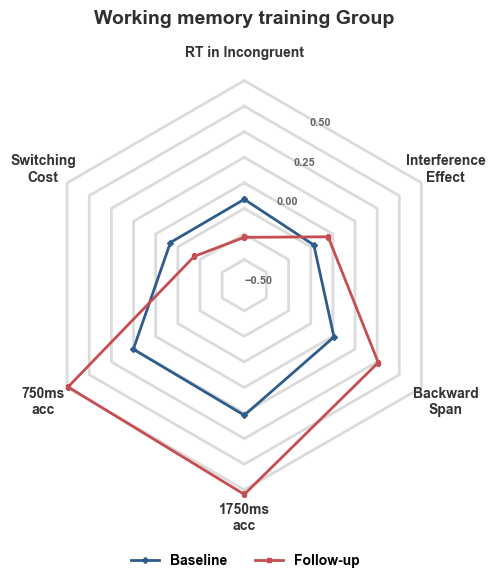

✅ 已生成组1雷达图：image/minimal_radar_group1.jpg


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

# -------------------------------
# 1. 数据准备
# -------------------------------
# 配置参数
DATA_FILE = Path('processed_data.xlsx')
OUTPUT_DIR = Path('./image')
OUTPUT_DIR.mkdir(exist_ok=True)

# 定义变量组
ef_vars_pretest = [
    "Incongruent_Pretest", 
    "Interference_Effect_Pretest", 

    "Backward_Span_Pretest", 
    "1750ms_Pretest", 
    "750ms_Pretest", 
    "Switching_Cost_Pretest"
]
ef_vars_posttest = [
    "Incongruent_Posttest", 
    "Interference_Effect_Posttest", 

    "Backward_Span_Posttest", 
    "1750ms_Posttest", 
    "750ms_Posttest", 
    "Switching_Cost_Posttest"
]

# 标签设置
labels = [
    "RT in Incongruent", 
    "Interference\nEffect", 

    "Backward\nSpan", 
    "1750ms\nacc", 
    "750ms\nacc", 
    "Switching\nCost"
]

# -------------------------------
# 2. 标准化函数（使用全样本基准）
# -------------------------------
def calculate_zscores(variables, group_data, full_data):
    """基于全样本的标准化计算"""
    return (group_data[variables] - full_data[variables].mean()) / full_data[variables].std()

# -------------------------------
# 3. 数据预处理
# -------------------------------
def prepare_radar_data(series_data):
    """处理雷达图数据闭合"""
    values = np.array(series_data.tolist())
    return np.concatenate((values, [values[0]]))

# -------------------------------
# 4. 智能坐标轴范围计算
# -------------------------------
def smart_ylim(*datasets):
    """自动计算合适的Y轴范围"""
    all_values = np.concatenate(datasets)
    max_val = np.nanmax(all_values)
    min_val = np.nanmin(all_values)
    
    buffer = 0.1 * (max_val - min_val)
    y_upper = np.ceil((max_val + buffer) * 2) / 2
    y_lower = np.floor((min_val - buffer) * 2) / 2
    return (y_lower, y_upper)

# -------------------------------
# 5. 极简雷达图绘制（添加可调参数）
# -------------------------------
def plot_minimal_radar(pretest, posttest, labels, group_name, color_pretest='#2F5C8A', color_posttest='#C44E52', 
                       line_width=2.5, marker_pretest='D', marker_posttest='s', marker_size=8, 
                       grid_color='#CCCCCC', grid_alpha=0.6, grid_linewidth=0.5, title_fontsize=14, 
                       custom_ylim=None, custom_yticks=None,
                       main_line_width=2.5, auxiliary_line_width=0.5):
    """改进版雷达图绘制函数，包含可调参数，主线条和辅助线条分开调节"""
    # 角度计算
    N = len(labels)
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
    angles += angles[:1]
    
    # 创建画布
    fig = plt.figure(figsize=(5.5, 6))
    ax = fig.add_subplot(111, polar=True)
    
    # 添加半透明环形背景
    for r in np.arange(-0.5, 0.75, 0.15):
        ax.plot(angles, [r]*len(angles), color='#CCCCCC', alpha=0.7, linewidth=2, zorder=0)
    
    # 绘制主数据线条
    ax.plot(angles, prepare_radar_data(pretest),
            color=color_pretest, linewidth=main_line_width, 
            marker=marker_pretest, markersize=marker_size, 
            label='Baseline')
    
    ax.plot(angles, prepare_radar_data(posttest),
            color=color_posttest, linewidth=main_line_width,
            marker=marker_posttest, markersize=marker_size,
            label='Follow-up')
    
    # 坐标轴设置
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    
    # 如果传入了自定义的Y轴范围，则使用该范围，否则自动计算
    if custom_ylim:
        ax.set_ylim(custom_ylim)
    else:
        ax.set_ylim(smart_ylim(pretest, posttest))
    
    # 如果传入了自定义的Y轴刻度，则使用该刻度
    if custom_yticks:
        ax.set_yticks(custom_yticks)
    
    # 绘制辅助网格线条（调整网格线的宽度）
    ax.grid(linewidth=auxiliary_line_width, alpha=grid_alpha, color=grid_color)
    ax.spines['polar'].set_visible(False)
    
    # 标签设置
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=10, color='#333333')
    plt.yticks(fontsize=8, color='#666666')
    
    # 图例和标题
    plt.legend(loc='upper right', bbox_to_anchor=(0.8, -0.1),
              frameon=False, fontsize=10,ncol=2)
    plt.title(f"Working memory training Group",
             fontsize=title_fontsize, pad=35, color='#2F2F2F',
              fontweight='bold')
    
    return fig

# -------------------------------
# 6. 主程序流程
# -------------------------------
if __name__ == "__main__":
    # 加载数据
    full_data = pd.read_excel(DATA_FILE)
    
    # 只处理Group 1
    group_id = 1  # 只选择组1
    group_mask = full_data['Group'] == group_id
    group_data = full_data[group_mask]
    
    # 计算标准化分数（基于全样本）
    pretest_z = calculate_zscores(ef_vars_pretest, group_data, full_data).mean()
    posttest_z = calculate_zscores(ef_vars_posttest, group_data, full_data).mean()
    
    # 自定义Y轴范围和刻度
    custom_ylim = (-0.5, 0.75)  # 自定义Y轴范围
    custom_yticks = [-0.5, 0, 0.25, 0.5]  # 自定义Y轴刻度
    
    # 生成图形
    fig = plot_minimal_radar(pretest_z, posttest_z, labels, f"Group {group_id}",
                             color_pretest='#2F5C8A', color_posttest='#C44E52', 
                             line_width=0.2, marker_pretest='D', marker_posttest='s', marker_size=3, 
                             grid_color='#CCCCCC', grid_alpha=1, grid_linewidth=0, title_fontsize=14,
                             custom_ylim=custom_ylim, custom_yticks=custom_yticks,
                             main_line_width=2, auxiliary_line_width=0)
    
    # 保存输出
    output_path = OUTPUT_DIR / f"minimal_radar_group{group_id}.jpg"
    plt.savefig(output_path, bbox_inches='tight', dpi=1200)
    plt.show()
    print(f"✅ 已生成组{group_id}雷达图：{output_path}")

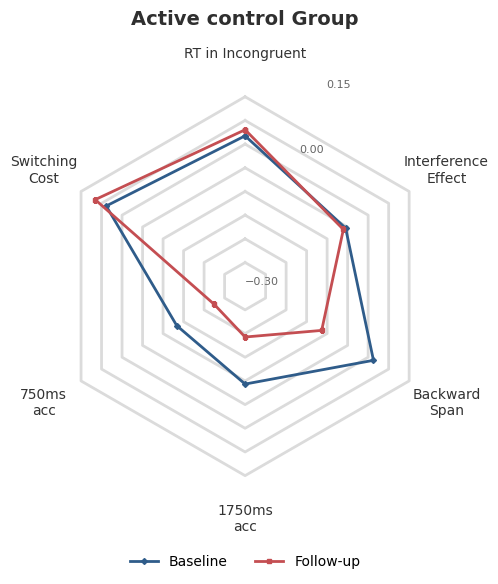

✅ 已生成组2雷达图：image/minimal_radar_group2.jpg


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

# -------------------------------
# 1. 数据准备
# -------------------------------
# 配置参数
DATA_FILE = Path('processed_data.xlsx')
OUTPUT_DIR = Path('./image')
OUTPUT_DIR.mkdir(exist_ok=True)

# 定义变量组
ef_vars_pretest = [
    "Incongruent_Pretest", 
    "Interference_Effect_Pretest", 

    "Backward_Span_Pretest", 
    "1750ms_Pretest", 
    "750ms_Pretest", 
    "Switching_Cost_Pretest"
]
ef_vars_posttest = [
    "Incongruent_Posttest", 
    "Interference_Effect_Posttest", 

    "Backward_Span_Posttest", 
    "1750ms_Posttest", 
    "750ms_Posttest", 
    "Switching_Cost_Posttest"
]

# 标签设置
labels = [
    "RT in Incongruent", 
    "Interference\nEffect", 

    "Backward\nSpan", 
    "1750ms\nacc", 
    "750ms\nacc", 
    "Switching\nCost"
]

# -------------------------------
# 2. 标准化函数（使用全样本基准）
# -------------------------------
def calculate_zscores(variables, group_data, full_data):
    """基于全样本的标准化计算"""
    return (group_data[variables] - full_data[variables].mean()) / full_data[variables].std()

# -------------------------------
# 3. 数据预处理
# -------------------------------
def prepare_radar_data(series_data):
    """处理雷达图数据闭合"""
    values = np.array(series_data.tolist())
    return np.concatenate((values, [values[0]]))

# -------------------------------
# 4. 智能坐标轴范围计算
# -------------------------------
def smart_ylim(*datasets):
    """自动计算合适的Y轴范围"""
    all_values = np.concatenate(datasets)
    max_val = np.nanmax(all_values)
    min_val = np.nanmin(all_values)
    
    buffer = 0.1 * (max_val - min_val)
    y_upper = np.ceil((max_val + buffer) * 2) / 2
    y_lower = np.floor((min_val - buffer) * 2) / 2
    return (y_lower, y_upper)

# -------------------------------
# 5. 极简雷达图绘制（添加可调参数）
# -------------------------------
def plot_minimal_radar(pretest, posttest, labels, group_name, color_pretest='#2F5C8A', color_posttest='#C44E52', 
                       line_width=2.5, marker_pretest='D', marker_posttest='s', marker_size=8, 
                       grid_color='#CCCCCC', grid_alpha=0.6, grid_linewidth=0.5, title_fontsize=14, 
                       custom_ylim=None, custom_yticks=None,
                       main_line_width=2.5, auxiliary_line_width=0.5):
    """改进版雷达图绘制函数，包含可调参数，主线条和辅助线条分开调节"""
    # 角度计算
    N = len(labels)
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
    angles += angles[:1]
    
    # 创建画布
    fig = plt.figure(figsize=(5.5, 6))
    ax = fig.add_subplot(111, polar=True)
    
    # 添加半透明环形背景
    for r in np.arange(-0.3, 0.15, 0.05):
        ax.plot(angles, [r]*len(angles), color='#CCCCCC', alpha=0.7, linewidth=2, zorder=0)
    
    # 绘制主数据线条
    ax.plot(angles, prepare_radar_data(pretest),
            color=color_pretest, linewidth=main_line_width, 
            marker=marker_pretest, markersize=marker_size, 
            label='Baseline')
    
    ax.plot(angles, prepare_radar_data(posttest),
            color=color_posttest, linewidth=main_line_width,
            marker=marker_posttest, markersize=marker_size,
            label='Follow-up')
    
    # 坐标轴设置
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    
    # 如果传入了自定义的Y轴范围，则使用该范围，否则自动计算
    if custom_ylim:
        ax.set_ylim(custom_ylim)
    else:
        ax.set_ylim(smart_ylim(pretest, posttest))
    
    # 如果传入了自定义的Y轴刻度，则使用该刻度
    if custom_yticks:
        ax.set_yticks(custom_yticks)
    
    # 绘制辅助网格线条（调整网格线的宽度）
    ax.grid(linewidth=auxiliary_line_width, alpha=grid_alpha, color=grid_color)
    ax.spines['polar'].set_visible(False)
    
    # 标签设置
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=10, color='#333333')
    plt.yticks(fontsize=8, color='#666666')
    
    # 图例和标题
    plt.legend(loc='upper right', bbox_to_anchor=(0.8, -0.1),
              frameon=False, fontsize=10,ncol=2)
    plt.title(f"Active control Group",
             fontsize=title_fontsize, pad=35, color='#2F2F2F',
              fontweight='bold')
    
    return fig

# -------------------------------
# 6. 主程序流程
# -------------------------------
if __name__ == "__main__":
    # 加载数据
    full_data = pd.read_excel(DATA_FILE)
    
    # 只处理Group 1
    group_id = 2  # 只选择组1
    group_mask = full_data['Group'] == group_id
    group_data = full_data[group_mask]
    
    # 计算标准化分数（基于全样本）
    pretest_z = calculate_zscores(ef_vars_pretest, group_data, full_data).mean()
    posttest_z = calculate_zscores(ef_vars_posttest, group_data, full_data).mean()
    
    # 自定义Y轴范围和刻度
    custom_ylim = (-0.3, 0.15)  # 自定义Y轴范围
    custom_yticks = [-0.3, 0, 0.15]  # 自定义Y轴刻度
    
    # 生成图形
    fig = plot_minimal_radar(pretest_z, posttest_z, labels, f"Group {group_id}",
                             color_pretest='#2F5C8A', color_posttest='#C44E52', 
                             line_width=0.2, marker_pretest='D', marker_posttest='s', marker_size=3, 
                             grid_color='#CCCCCC', grid_alpha=1, grid_linewidth=0, title_fontsize=14,
                             custom_ylim=custom_ylim, custom_yticks=custom_yticks,
                             main_line_width=2, auxiliary_line_width=0)
    
    # 保存输出
    output_path = OUTPUT_DIR / f"minimal_radar_group{group_id}.jpg"
    plt.savefig(output_path, bbox_inches='tight', dpi=1200)
    plt.show()
    print(f"✅ 已生成组{group_id}雷达图：{output_path}")

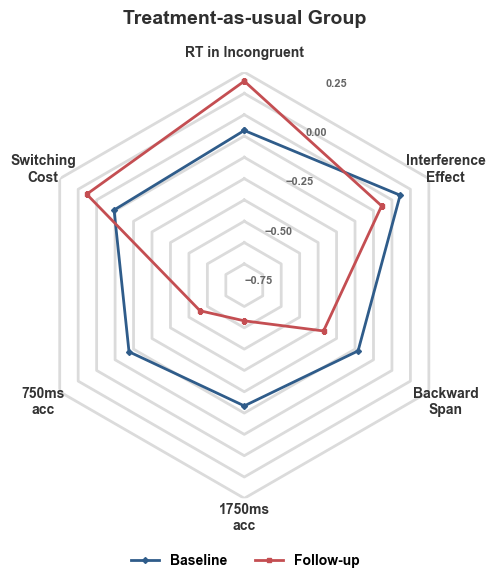

✅ 已生成组3雷达图：image/minimal_radar_group3.jpg


In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

# -------------------------------
# 1. 数据准备
# -------------------------------
# 配置参数
DATA_FILE = Path('processed_data.xlsx')
OUTPUT_DIR = Path('./image')
OUTPUT_DIR.mkdir(exist_ok=True)

# 定义变量组
ef_vars_pretest = [
    "Incongruent_Pretest", 
    "Interference_Effect_Pretest", 

    "Backward_Span_Pretest", 
    "1750ms_Pretest", 
    "750ms_Pretest", 
    "Switching_Cost_Pretest"
]
ef_vars_posttest = [
    "Incongruent_Posttest", 
    "Interference_Effect_Posttest", 

    "Backward_Span_Posttest", 
    "1750ms_Posttest", 
    "750ms_Posttest", 
    "Switching_Cost_Posttest"
]

# 标签设置
labels = [
    "RT in Incongruent", 
    "Interference\nEffect", 

    "Backward\nSpan", 
    "1750ms\nacc", 
    "750ms\nacc", 
    "Switching\nCost"
]

# -------------------------------
# 2. 标准化函数（使用全样本基准）
# -------------------------------
def calculate_zscores(variables, group_data, full_data):
    """基于全样本的标准化计算"""
    return (group_data[variables] - full_data[variables].mean()) / full_data[variables].std()

# -------------------------------
# 3. 数据预处理
# -------------------------------
def prepare_radar_data(series_data):
    """处理雷达图数据闭合"""
    values = np.array(series_data.tolist())
    return np.concatenate((values, [values[0]]))

# -------------------------------
# 4. 智能坐标轴范围计算
# -------------------------------
def smart_ylim(*datasets):
    """自动计算合适的Y轴范围"""
    all_values = np.concatenate(datasets)
    max_val = np.nanmax(all_values)
    min_val = np.nanmin(all_values)
    
    buffer = 0.1 * (max_val - min_val)
    y_upper = np.ceil((max_val + buffer) * 2) / 2
    y_lower = np.floor((min_val - buffer) * 2) / 2
    return (y_lower, y_upper)

# -------------------------------
# 5. 极简雷达图绘制（添加可调参数）
# -------------------------------
def plot_minimal_radar(pretest, posttest, labels, group_name, color_pretest='#2F5C8A', color_posttest='#C44E52', 
                       line_width=2.5, marker_pretest='D', marker_posttest='s', marker_size=8, 
                       grid_color='#CCCCCC', grid_alpha=0.6, grid_linewidth=0.5, title_fontsize=14, 
                       custom_ylim=None, custom_yticks=None,
                       main_line_width=2.5, auxiliary_line_width=0.5):
    """改进版雷达图绘制函数，包含可调参数，主线条和辅助线条分开调节"""
    # 角度计算
    N = len(labels)
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
    angles += angles[:1]
    
    # 创建画布
    fig = plt.figure(figsize=(5.5, 6))
    ax = fig.add_subplot(111, polar=True)
    
    # 添加半透明环形背景
    for r in np.arange(-0.75, 0.35, 0.1):
        ax.plot(angles, [r]*len(angles), color='#CCCCCC', alpha=0.7, linewidth=2, zorder=0)
    
    # 绘制主数据线条
    ax.plot(angles, prepare_radar_data(pretest),
            color=color_pretest, linewidth=main_line_width, 
            marker=marker_pretest, markersize=marker_size, 
            label='Baseline')
    
    ax.plot(angles, prepare_radar_data(posttest),
            color=color_posttest, linewidth=main_line_width,
            marker=marker_posttest, markersize=marker_size,
            label='Follow-up')
    
    # 坐标轴设置
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    
    # 如果传入了自定义的Y轴范围，则使用该范围，否则自动计算
    if custom_ylim:
        ax.set_ylim(custom_ylim)
    else:
        ax.set_ylim(smart_ylim(pretest, posttest))
    
    # 如果传入了自定义的Y轴刻度，则使用该刻度
    if custom_yticks:
        ax.set_yticks(custom_yticks)
    
    # 绘制辅助网格线条（调整网格线的宽度）
    ax.grid(linewidth=auxiliary_line_width, alpha=grid_alpha, color=grid_color)
    ax.spines['polar'].set_visible(False)
    
    # 标签设置
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=10, color='#333333')
    plt.yticks(fontsize=8, color='#666666')
    
    # 图例和标题
    plt.legend(loc='upper right', bbox_to_anchor=(0.8, -0.1),
              frameon=False, fontsize=10,ncol=2)
    plt.title(f"Treatment-as-usual Group",
             fontsize=title_fontsize, pad=35, color='#2F2F2F',
              fontweight='bold')
    
    return fig

# -------------------------------
# 6. 主程序流程
# -------------------------------
if __name__ == "__main__":
    # 加载数据
    full_data = pd.read_excel(DATA_FILE)
    
    # 只处理Group 1
    group_id = 3  # 只选择组1
    group_mask = full_data['Group'] == group_id
    group_data = full_data[group_mask]
    
    # 计算标准化分数（基于全样本）
    pretest_z = calculate_zscores(ef_vars_pretest, group_data, full_data).mean()
    posttest_z = calculate_zscores(ef_vars_posttest, group_data, full_data).mean()
    
    # 自定义Y轴范围和刻度
    custom_ylim = (-0.75, 0.25)  # 自定义Y轴范围
    custom_yticks = [-0.75,-0.5,-0.25,0,0.25]  # 自定义Y轴刻度
    
    # 生成图形
    fig = plot_minimal_radar(pretest_z, posttest_z, labels, f"Group {group_id}",
                             color_pretest='#2F5C8A', color_posttest='#C44E52', 
                             line_width=0.2, marker_pretest='D', marker_posttest='s', marker_size=3, 
                             grid_color='#CCCCCC', grid_alpha=1, grid_linewidth=0, title_fontsize=14,
                             custom_ylim=custom_ylim, custom_yticks=custom_yticks,
                             main_line_width=2, auxiliary_line_width=0)
    
    # 保存输出
    output_path = OUTPUT_DIR / f"minimal_radar_group{group_id}.jpg"
    plt.savefig(output_path, bbox_inches='tight', dpi=1200)
    plt.show()
    print(f"✅ 已生成组{group_id}雷达图：{output_path}")

## 4.基线比较

## 6.前后测方差分析

In [19]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm
from statsmodels.stats.multicomp import MultiComparison
import warnings

warnings.filterwarnings('ignore')

# 读取数据
file_name = 'processed_data.xlsx'
data = pd.read_excel(file_name)

# 定义 EF 变量（含 Pretest 和 Posttest）
ef_variables = [
    "NoGo_Accuracy"
]

# 添加 Subject 列（用于 LMM 分析的随机效应）
data['Subject'] = data.index
data = data.reset_index(drop=True)

# 确保所需列存在
required_columns = ["Group", "Subject"] + [
    f"{var}_Pretest" for var in ef_variables
] + [
    f"{var}_Posttest" for var in ef_variables
]

missing_columns = [col for col in required_columns if col not in data.columns]
if missing_columns:
    raise KeyError(f"The following required columns are missing from the data: {missing_columns}")

# 创建字典以存储结果
results = {}

# 对每个变量进行线性混合效应模型分析
def perform_lmm_analysis(ef_var):
    # 数据重塑为长格式
    df_long = pd.melt(
        data,
        id_vars=["Group", "Subject"],
        value_vars=[f"{ef_var}_Pretest", f"{ef_var}_Posttest"],
        var_name='Time', value_name='Score'
    )
    
    df_long['Time'] = df_long['Time'].map({f"{ef_var}_Pretest": 0, f"{ef_var}_Posttest": 1})
    df_long['Group'] = df_long['Group'].astype('category')

    # 定义线性混合效应模型公式
    formula = "Score ~ Time * Group"
    
    md = mixedlm(formula, df_long, groups=df_long["Subject"], re_formula="~Time")
    mdf = md.fit()
    
    # 提取固定效应的 p 值
    p_values = mdf.pvalues.loc[['Time', 'Group[T.2]', 'Group[T.3]', 'Time:Group[T.2]', 'Time:Group[T.3]']]
    
    # 不进行FDR校正，直接返回原始p值
    p_values_corrected_dict = p_values.to_dict()

    # 存储结果
    return {
        'LMM_summary': mdf.summary(),
        'p_values': p_values,
        'p_values_corrected': p_values_corrected_dict,
        'df_long': df_long  # Store the long format data for post-hoc analysis
    }

# 对每个变量进行分析并存储结果
for ef_var in ef_variables:
    results[ef_var] = perform_lmm_analysis(ef_var)

# 输出结果
for ef_var, result in results.items():
    print(f"\n--- Results for {ef_var} ---")
    print(result['LMM_summary'])
    
    # 显示未校正的显著性结果
    print("\nRaw p-values:")
    for term, corrected_p in result['p_values_corrected'].items():
        print(f"{term}: {corrected_p:.3f}")

    # 仅在 p < 0.05 时进行事后比较（显著交互作用）
    interaction_terms = ['Time:Group[T.2]', 'Time:Group[T.3]']
    if any(result['p_values_corrected'][term] < 0.05 for term in interaction_terms):  # 检查显著交互作用
        print("\nSignificant interaction detected. Performing post-hoc analysis...")
        
        mc = MultiComparison(result['df_long']['Score'], 
                             result['df_long']['Time'].astype(str) + "_" + result['df_long']['Group'].astype(str))
        post_hoc_results = mc.tukeyhsd(alpha=0.05)
        
        # 输出 Tukey HSD 结果
        print("\n--- Tukey HSD Post-Hoc Results ---")
        summary_df = pd.DataFrame(data=post_hoc_results.summary().data[1:], columns=post_hoc_results.summary().data[0])
        print(summary_df)

        # 输出均值和标准差
        means = result['df_long'].groupby(['Time', 'Group'])['Score'].agg(['mean', 'std']).reset_index()
        means['Group'] = means['Group'].map({1: 'Group 1', 2: 'Group 2', 3: 'Group 3'})
        means['Time'] = means['Time'].map({0: 'Pretest', 1: 'Posttest'})
        
        print("\n--- Means and Standard Deviations ---")
        print(means)

import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm
import numpy as np

# 读取数据
file_name = 'processed_data.xlsx'
data = pd.read_excel(file_name)

# 定义 EF 变量（含 Pretest 和 Posttest）
ef_variables = ["NoGo_Accuracy"]

# 控制变量
control_variables = ["Age", "Olanzapine_Equivalent", "Education_Years", "Gender"]

# 添加 Subject 列（用于 LMM 分析的随机效应）
data['Subject'] = data.index
data = data.reset_index(drop=True)

# 确保所需列存在
required_columns = ["Group", "Subject"] + control_variables + [
    f"{var}_Pretest" for var in ef_variables
] + [
    f"{var}_Posttest" for var in ef_variables
]

missing_columns = [col for col in required_columns if col not in data.columns]
if missing_columns:
    raise KeyError(f"The following required columns are missing from the data: {missing_columns}")

# 创建字典以存储结果
results = {}

# 对每个变量进行线性混合效应模型分析
def perform_lmm_analysis(ef_var):
    # 数据重塑为长格式
    df_long = pd.melt(
        data,
        id_vars=["Group", "Subject"] + control_variables,
        value_vars=[f"{ef_var}_Pretest", f"{ef_var}_Posttest"],
        var_name='Time', value_name='Score'
    )
    
    df_long['Time'] = df_long['Time'].map({f"{ef_var}_Pretest": 0, f"{ef_var}_Posttest": 1})
    df_long['Group'] = df_long['Group'].astype('category')

    # 定义线性混合效应模型公式
    formula = "Score ~ Time * Group + " + " + ".join(control_variables)
    
    md = mixedlm(formula, df_long, groups=df_long["Subject"], re_formula="~Time")
    mdf = md.fit()
    
    # 提取固定效应的 p 值
    p_values = mdf.pvalues.to_dict()
    
    # 进行总体效应的联合假设检验
    group_effect = mdf.wald_test(np.eye(len(mdf.params))[1:3], use_f=True)
    interaction_effect = mdf.wald_test(np.eye(len(mdf.params))[4:6], use_f=True)
    
    # 存储结果
    return {
        'LMM_summary': mdf.summary(),
        'p_values': p_values,
        'group_effect': group_effect,
        'interaction_effect': interaction_effect
    }

# 对每个变量进行分析并存储结果
for ef_var in ef_variables:
    results[ef_var] = perform_lmm_analysis(ef_var)

# 输出结果
for ef_var, result in results.items():
    print(f"\n--- Results for {ef_var} ---")
    print(result['LMM_summary'])
    
    print("\nP-values:")
    print(result['p_values'])
    
    print("\nGroup main effect:")
    print(result['group_effect'])
    
    print("\nTime:Group interaction effect:")
    print(result['interaction_effect'])


--- Results for NoGo_Accuracy ---
           Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  Score   
No. Observations:    188      Method:              REML    
No. Groups:          94       Scale:               0.0100  
Min. group size:     2        Log-Likelihood:      104.2855
Max. group size:     2        Converged:           Yes     
Mean group size:     2.0                                   
-----------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept         0.849    0.022 38.400 0.000  0.806  0.893
Group[T.2]       -0.054    0.031 -1.752 0.080 -0.115  0.006
Group[T.3]       -0.030    0.032 -0.943 0.346 -0.093  0.033
Time              0.027    0.030  0.887 0.375 -0.032  0.085
Time:Group[T.2]  -0.077    0.042 -1.828 0.068 -0.159  0.006
Time:Group[T.3]  -0.058    0.043 -1.325 0.185 -0.143  0.028
Group Var       

In [20]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm
from statsmodels.stats.multicomp import MultiComparison
import numpy as np
import warnings

warnings.filterwarnings('ignore')

# 读取数据
file_name = 'processed_data.xlsx'
data = pd.read_excel(file_name)

# 定义 EF 变量（含 Baseline 和 Followup）
ef_variables = [
    "PANSS_G"
]

# 控制变量
control_variables = ["Age", "Olanzapine_Equivalent", "Education_Years", "Gender"]

# 添加 Subject 列（用于 LMM 分析的随机效应）
data['Subject'] = data.index
data = data.reset_index(drop=True)

# 确保所需列存在
required_columns = ["Group", "Subject"] + control_variables + [
    f"{var}_Baseline" for var in ef_variables
] + [
    f"{var}_Followup" for var in ef_variables
]

missing_columns = [col for col in required_columns if col not in data.columns]
if missing_columns:
    raise KeyError(f"The following required columns are missing from the data: {missing_columns}")

# 创建字典以存储结果
results = {}

# 对每个变量进行线性混合效应模型分析
def perform_lmm_analysis(ef_var):
    # 数据重塑为长格式
    df_long = pd.melt(
        data,
        id_vars=["Group", "Subject"] + control_variables,
        value_vars=[f"{ef_var}_Baseline", f"{ef_var}_Followup"],
        var_name='Time', value_name='Score'
    )
    
    df_long['Time'] = df_long['Time'].map({f"{ef_var}_Baseline": 0, f"{ef_var}_Followup": 1})
    df_long['Group'] = df_long['Group'].astype('category')

    # 定义线性混合效应模型公式
    formula = "Score ~ Time * Group + " + " + ".join(control_variables)
    
    md = mixedlm(formula, df_long, groups=df_long["Subject"], re_formula="~Time")
    mdf = md.fit()
    
    # 提取固定效应的 p 值
    p_values = mdf.pvalues.to_dict()
    
    # 进行总体效应的联合假设检验
    group_effect = mdf.wald_test(np.eye(len(mdf.params))[1:3], use_f=True)
    interaction_effect = mdf.wald_test(np.eye(len(mdf.params))[4:6], use_f=True)
    
    # 存储结果
    return {
        'LMM_summary': mdf.summary(),
        'p_values': p_values,
        'group_effect': group_effect,
        'interaction_effect': interaction_effect,
        'df_long': df_long  # 保存长格式数据用于事后分析
    }

# 对每个变量进行分析并存储结果
for ef_var in ef_variables:
    results[ef_var] = perform_lmm_analysis(ef_var)

# 输出结果
for ef_var, result in results.items():
    print(f"\n--- Results for {ef_var} ---")
    print(result['LMM_summary'])
    
    print("\nP-values:")
    print(result['p_values'])
    
    print("\nGroup main effect:")
    print(result['group_effect'])
    
    print("\nTime:Group interaction effect:")
    print(result['interaction_effect'])

    # 检查显著交互作用，进行事后比较
    interaction_terms = ['Time:Group[T.2]', 'Time:Group[T.3]']
    if any(result['p_values'][term] < 0.05 for term in interaction_terms):
        print("\nSignificant interaction detected. Performing post-hoc analysis...")
        
        mc = MultiComparison(result['df_long']['Score'], 
                             result['df_long']['Time'].astype(str) + "_" + result['df_long']['Group'].astype(str))
        post_hoc_results = mc.tukeyhsd(alpha=0.05)
        
        # 输出 Tukey HSD 结果
        print("\n--- Tukey HSD Post-Hoc Results ---")
        summary_df = pd.DataFrame(data=post_hoc_results.summary().data[1:], columns=post_hoc_results.summary().data[0])
        print(summary_df)

        # 输出均值和标准差
        means = result['df_long'].groupby(['Time', 'Group'])['Score'].agg(['mean', 'std']).reset_index()
        means['Group'] = means['Group'].map({1: 'Group 1', 2: 'Group 2', 3: 'Group 3'})
        means['Time'] = means['Time'].map({0: 'Baseline', 1: 'Followup'})
        
        print("\n--- Means and Standard Deviations ---")
        print(means)


--- Results for PANSS_G ---
               Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     Score    
No. Observations:      188         Method:                 REML     
No. Groups:            94          Scale:                  16.3543  
Min. group size:       2           Log-Likelihood:         -651.2491
Max. group size:       2           Converged:              No       
Mean group size:       2.0                                          
--------------------------------------------------------------------
                       Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
--------------------------------------------------------------------
Intercept               29.760    3.884  7.663 0.000  22.148  37.372
Group[T.2]              -3.368    3.069 -1.097 0.272  -9.383   2.647
Group[T.3]              -1.715    3.170 -0.541 0.589  -7.928   4.499
Time                   -15.531    2.307 -6.732 0.000 -20.053 -11.009
Time:Group[T.2]      

In [21]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm
from statsmodels.stats.multicomp import MultiComparison
import warnings

warnings.filterwarnings('ignore')

# 读取数据
file_name = 'processed_data.xlsx'
data = pd.read_excel(file_name)

# 定义 EF 变量（含 Pretest 和 Posttest）
ef_variables = [
    "750ms"
]

# 添加 Subject 列（用于 LMM 分析的随机效应）
data['Subject'] = data.index
data = data.reset_index(drop=True)

# 确保所需列存在
required_columns = ["Group", "Subject"] + [
    f"{var}_Pretest" for var in ef_variables
] + [
    f"{var}_Posttest" for var in ef_variables
]

missing_columns = [col for col in required_columns if col not in data.columns]
if missing_columns:
    raise KeyError(f"The following required columns are missing from the data: {missing_columns}")

# 创建字典以存储结果
results = {}

# 对每个变量进行线性混合效应模型分析
def perform_lmm_analysis(ef_var):
    # 数据重塑为长格式
    df_long = pd.melt(
        data,
        id_vars=["Group", "Subject"],
        value_vars=[f"{ef_var}_Pretest", f"{ef_var}_Posttest"],
        var_name='Time', value_name='Score'
    )
    
    df_long['Time'] = df_long['Time'].map({f"{ef_var}_Pretest": 0, f"{ef_var}_Posttest": 1})
    df_long['Group'] = df_long['Group'].astype('category')

    # 定义线性混合效应模型公式
    formula = "Score ~ Time * Group"
    
    md = mixedlm(formula, df_long, groups=df_long["Subject"], re_formula="~Time")
    mdf = md.fit()
    
    # 提取固定效应的 p 值
    p_values = mdf.pvalues.loc[['Time', 'Group[T.2]', 'Group[T.3]', 'Time:Group[T.2]', 'Time:Group[T.3]']]
    
    # 不进行FDR校正，直接返回原始p值
    p_values_corrected_dict = p_values.to_dict()

    # 存储结果
    return {
        'LMM_summary': mdf.summary(),
        'p_values': p_values,
        'p_values_corrected': p_values_corrected_dict,
        'df_long': df_long  # Store the long format data for post-hoc analysis
    }

# 对每个变量进行分析并存储结果
for ef_var in ef_variables:
    results[ef_var] = perform_lmm_analysis(ef_var)

# 输出结果
for ef_var, result in results.items():
    print(f"\n--- Results for {ef_var} ---")
    print(result['LMM_summary'])
    
    # 显示未校正的显著性结果
    print("\nRaw p-values:")
    for term, corrected_p in result['p_values_corrected'].items():
        print(f"{term}: {corrected_p:.3f}")

    # 仅在 p < 0.05 时进行事后比较（显著交互作用）
    interaction_terms = ['Time:Group[T.2]', 'Time:Group[T.3]']
    if any(result['p_values_corrected'][term] < 0.05 for term in interaction_terms):  # 检查显著交互作用
        print("\nSignificant interaction detected. Performing post-hoc analysis...")
        
        mc = MultiComparison(result['df_long']['Score'], 
                             result['df_long']['Time'].astype(str) + "_" + result['df_long']['Group'].astype(str))
        post_hoc_results = mc.tukeyhsd(alpha=0.05)
        
        # 输出 Tukey HSD 结果
        print("\n--- Tukey HSD Post-Hoc Results ---")
        summary_df = pd.DataFrame(data=post_hoc_results.summary().data[1:], columns=post_hoc_results.summary().data[0])
        print(summary_df)

        # 输出均值和标准差
        means = result['df_long'].groupby(['Time', 'Group'])['Score'].agg(['mean', 'std']).reset_index()
        means['Group'] = means['Group'].map({1: 'Group 1', 2: 'Group 2', 3: 'Group 3'})
        means['Time'] = means['Time'].map({0: 'Pretest', 1: 'Posttest'})
        
        print("\n--- Means and Standard Deviations ---")
        print(means)

import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm
import numpy as np

# 读取数据
file_name = 'processed_data.xlsx'
data = pd.read_excel(file_name)

# 定义 EF 变量（含 Pretest 和 Posttest）
ef_variables = ["750ms"]

# 控制变量
control_variables = ["Age", "Olanzapine_Equivalent", "Education_Years", "Gender"]

# 添加 Subject 列（用于 LMM 分析的随机效应）
data['Subject'] = data.index
data = data.reset_index(drop=True)

# 确保所需列存在
required_columns = ["Group", "Subject"] + control_variables + [
    f"{var}_Pretest" for var in ef_variables
] + [
    f"{var}_Posttest" for var in ef_variables
]

missing_columns = [col for col in required_columns if col not in data.columns]
if missing_columns:
    raise KeyError(f"The following required columns are missing from the data: {missing_columns}")

# 创建字典以存储结果
results = {}

# 对每个变量进行线性混合效应模型分析
def perform_lmm_analysis(ef_var):
    # 数据重塑为长格式
    df_long = pd.melt(
        data,
        id_vars=["Group", "Subject"] + control_variables,
        value_vars=[f"{ef_var}_Pretest", f"{ef_var}_Posttest"],
        var_name='Time', value_name='Score'
    )
    
    df_long['Time'] = df_long['Time'].map({f"{ef_var}_Pretest": 0, f"{ef_var}_Posttest": 1})
    df_long['Group'] = df_long['Group'].astype('category')

    # 定义线性混合效应模型公式
    formula = "Score ~ Time * Group + " + " + ".join(control_variables)
    
    md = mixedlm(formula, df_long, groups=df_long["Subject"], re_formula="~Time")
    mdf = md.fit()
    
    # 提取固定效应的 p 值
    p_values = mdf.pvalues.to_dict()
    
    # 进行总体效应的联合假设检验
    group_effect = mdf.wald_test(np.eye(len(mdf.params))[1:3], use_f=True)
    interaction_effect = mdf.wald_test(np.eye(len(mdf.params))[4:6], use_f=True)
    
    # 存储结果
    return {
        'LMM_summary': mdf.summary(),
        'p_values': p_values,
        'group_effect': group_effect,
        'interaction_effect': interaction_effect
    }

# 对每个变量进行分析并存储结果
for ef_var in ef_variables:
    results[ef_var] = perform_lmm_analysis(ef_var)

# 输出结果
for ef_var, result in results.items():
    print(f"\n--- Results for {ef_var} ---")
    print(result['LMM_summary'])
    
    print("\nP-values:")
    print(result['p_values'])
    
    print("\nGroup main effect:")
    print(result['group_effect'])
    
    print("\nTime:Group interaction effect:")
    print(result['interaction_effect'])


--- Results for 750ms ---
           Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  Score   
No. Observations:    188      Method:              REML    
No. Groups:          94       Scale:               0.0377  
Min. group size:     2        Log-Likelihood:      -38.0102
Max. group size:     2        Converged:           Yes     
Mean group size:     2.0                                   
-----------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept         0.510    0.054  9.489 0.000  0.405  0.616
Group[T.2]       -0.118    0.075 -1.560 0.119 -0.266  0.030
Group[T.3]       -0.115    0.078 -1.478 0.139 -0.268  0.038
Time              0.222    0.055  4.051 0.000  0.115  0.329
Time:Group[T.2]  -0.194    0.077 -2.525 0.012 -0.345 -0.043
Time:Group[T.3]  -0.294    0.079 -3.698 0.000 -0.449 -0.138
Group Var         0.055 

In [22]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.multicomp import MultiComparison
import warnings

warnings.filterwarnings('ignore')

# 读取数据
file_name = 'processed_data.xlsx'
data = pd.read_excel(file_name)

# 定义 EF 变量（含 Pretest 和 Posttest）
ef_variables = [
    "Incongruent", "Interference_Effect", "Forward_Span", 
    "Backward_Span", "1750ms", "750ms", 
    "Switching_Cost", "NoGo_Accuracy"
]

# 控制变量
control_variables = ["Age", "Olanzapine_Equivalent", "Education_Years", "Gender"]

# 添加 Subject 列（用于 LMM 分析的随机效应）
data['Subject'] = data.index
data = data.reset_index(drop=True)

# 确保所需列存在
required_columns = ["Group", "Subject"] + [
    f"{var}_Pretest" for var in ef_variables
] + [
    f"{var}_Posttest" for var in ef_variables
] + control_variables

missing_columns = [col for col in required_columns if col not in data.columns]
if missing_columns:
    raise KeyError(f"The following required columns are missing from the data: {missing_columns}")

# 创建字典以存储结果
results = {}

# 对每个变量进行线性混合效应模型分析
def perform_lmm_analysis(ef_var):
    # 数据重塑为长格式
    df_long = pd.melt(
        data,
        id_vars=["Group", "Subject"] + control_variables,
        value_vars=[f"{ef_var}_Pretest", f"{ef_var}_Posttest"],
        var_name='Time', value_name='Score'
    )
    
    df_long['Time'] = df_long['Time'].map({f"{ef_var}_Pretest": 0, f"{ef_var}_Posttest": 1})
    df_long['Group'] = df_long['Group'].astype('category')
    
    # 哑变量生成
    df_long = pd.get_dummies(df_long, columns=['Gender'], drop_first=True)

    # 定义线性混合效应模型公式
    formula = ("Score ~ Time * Group + Age + Olanzapine_Equivalent + "
               "Education_Years + " +
               " + ".join(df_long.columns[df_long.columns.str.startswith(('Gender_'))]))
    
    md = mixedlm(formula, df_long, groups=df_long["Subject"], re_formula="~Time")
    mdf = md.fit()
    
    # 提取固定效应的 p 值
    p_values = mdf.pvalues.loc[['Time', 'Group[T.2]', 'Group[T.3]', 'Time:Group[T.2]', 'Time:Group[T.3]']]
    
    # 多重比较校正
    _, p_values_corrected, _, _ = multipletests(p_values, method='fdr_bh', is_sorted=False)
    p_values_corrected_dict = dict(zip(p_values.index, p_values_corrected))

    # 存储结果
    return {
        'LMM_summary': mdf.summary(),
        'p_values': p_values,
        'p_values_corrected': p_values_corrected_dict,
        'df_long': df_long  # Store the long format data for post-hoc analysis
    }

# 对每个变量进行分析并存储结果
for ef_var in ef_variables:
    results[ef_var] = perform_lmm_analysis(ef_var)

# 输出结果
for ef_var, result in results.items():
    print(f"\n--- Results for {ef_var} ---")
    print(result['LMM_summary'])
    
    # 显示校正后的显著性结果
    print("\nCorrected p-values:")
    for term, corrected_p in result['p_values_corrected'].items():
        print(f"{term}: {corrected_p:.3f}")

    # 进行事后比较（显著交互作用）
    interaction_terms = ['Time:Group[T.2]', 'Time:Group[T.3]']
    if any(result['p_values_corrected'][term] < 0.1 for term in interaction_terms):  # 检查显著交互作用
        print("\nSignificant interaction detected. Performing post-hoc analysis...")
        
        mc = MultiComparison(result['df_long']['Score'], 
                             result['df_long']['Time'].astype(str) + "_" + result['df_long']['Group'].astype(str))
        post_hoc_results = mc.tukeyhsd(alpha=0.05)
        
        # 输出 Tukey HSD 结果
        print("\n--- Tukey HSD Post-Hoc Results ---")
        summary_df = pd.DataFrame(data=post_hoc_results.summary().data[1:], columns=post_hoc_results.summary().data[0])
        print(summary_df)

        # 输出均值和标准差
        means = result['df_long'].groupby(['Time', 'Group'])['Score'].agg(['mean', 'std']).reset_index()
        means['Group'] = means['Group'].map({1: 'Group 1', 2: 'Group 2', 3: 'Group 3'})
        means['Time'] = means['Time'].map({0: 'Pretest', 1: 'Posttest'})
        
        print("\n--- Means and Standard Deviations ---")
        print(means)



--- Results for Incongruent ---
                 Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      Score     
No. Observations:      188          Method:                  REML      
No. Groups:            94           Scale:                   12560.5456
Min. group size:       2            Log-Likelihood:          -1169.0499
Max. group size:       2            Converged:               Yes       
Mean group size:       2.0                                             
-----------------------------------------------------------------------
                        Coef.    Std.Err.   z    P>|z|  [0.025   0.975]
-----------------------------------------------------------------------
Intercept                657.623   78.943  8.330 0.000  502.897 812.349
Group[T.2]                -1.407   44.389 -0.032 0.975  -88.408  85.595
Group[T.3]                -4.015   45.827 -0.088 0.930  -93.834  85.804
Time                     -88.687   32.038 -2.768

/Users/zhangtongyi/Vs_code/venv2_ml/lib/python3.10/site-packages/seaborn/categorical.py:1154: UserWarning: You passed a edgecolor/edgecolors ('#303030') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(cat_pos, strip_data, **kws)
/Users/zhangtongyi/Vs_code/venv2_ml/lib/python3.10/site-packages/seaborn/categorical.py:1154: UserWarning: You passed a edgecolor/edgecolors ('#303030') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(cat_pos, strip_data, **kws)
/Users/zhangtongyi/Vs_code/venv2_ml/lib/python3.10/site-packages/seaborn/categorical.py:1154: UserWarning: You passed a edgecolor/edgecolors ('#303030') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(cat_pos, strip_data, **kws)
/Users/zha

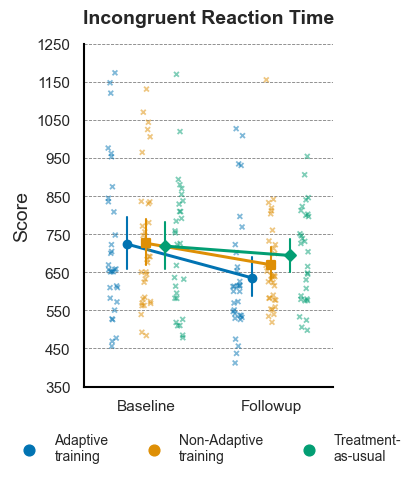

/Users/zhangtongyi/Vs_code/venv2_ml/lib/python3.10/site-packages/seaborn/categorical.py:1154: UserWarning: You passed a edgecolor/edgecolors ('#303030') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(cat_pos, strip_data, **kws)
/Users/zhangtongyi/Vs_code/venv2_ml/lib/python3.10/site-packages/seaborn/categorical.py:1154: UserWarning: You passed a edgecolor/edgecolors ('#303030') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(cat_pos, strip_data, **kws)
/Users/zhangtongyi/Vs_code/venv2_ml/lib/python3.10/site-packages/seaborn/categorical.py:1154: UserWarning: You passed a edgecolor/edgecolors ('#303030') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(cat_pos, strip_data, **kws)
/Users/zha

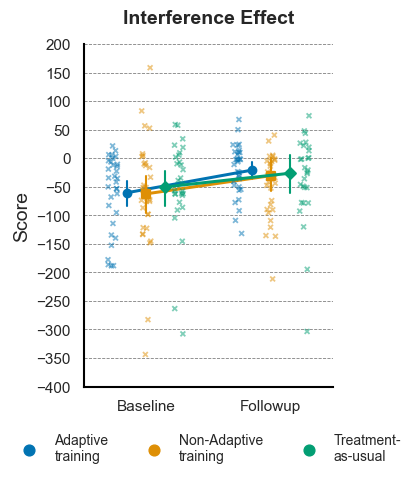

/Users/zhangtongyi/Vs_code/venv2_ml/lib/python3.10/site-packages/seaborn/categorical.py:1154: UserWarning: You passed a edgecolor/edgecolors ('#303030') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(cat_pos, strip_data, **kws)
/Users/zhangtongyi/Vs_code/venv2_ml/lib/python3.10/site-packages/seaborn/categorical.py:1154: UserWarning: You passed a edgecolor/edgecolors ('#303030') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(cat_pos, strip_data, **kws)
/Users/zhangtongyi/Vs_code/venv2_ml/lib/python3.10/site-packages/seaborn/categorical.py:1154: UserWarning: You passed a edgecolor/edgecolors ('#303030') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(cat_pos, strip_data, **kws)
/Users/zha

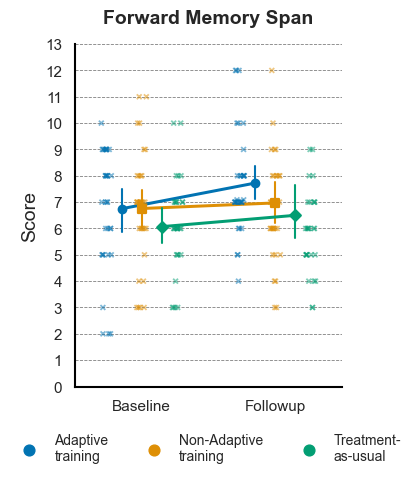

/Users/zhangtongyi/Vs_code/venv2_ml/lib/python3.10/site-packages/seaborn/categorical.py:1154: UserWarning: You passed a edgecolor/edgecolors ('#303030') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(cat_pos, strip_data, **kws)
/Users/zhangtongyi/Vs_code/venv2_ml/lib/python3.10/site-packages/seaborn/categorical.py:1154: UserWarning: You passed a edgecolor/edgecolors ('#303030') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(cat_pos, strip_data, **kws)
/Users/zhangtongyi/Vs_code/venv2_ml/lib/python3.10/site-packages/seaborn/categorical.py:1154: UserWarning: You passed a edgecolor/edgecolors ('#303030') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(cat_pos, strip_data, **kws)
/Users/zha

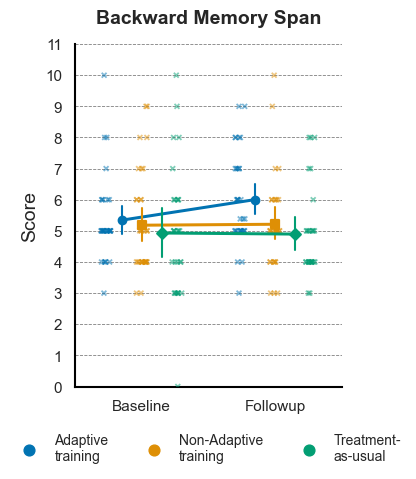

/Users/zhangtongyi/Vs_code/venv2_ml/lib/python3.10/site-packages/seaborn/categorical.py:1154: UserWarning: You passed a edgecolor/edgecolors ('#303030') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(cat_pos, strip_data, **kws)
/Users/zhangtongyi/Vs_code/venv2_ml/lib/python3.10/site-packages/seaborn/categorical.py:1154: UserWarning: You passed a edgecolor/edgecolors ('#303030') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(cat_pos, strip_data, **kws)
/Users/zhangtongyi/Vs_code/venv2_ml/lib/python3.10/site-packages/seaborn/categorical.py:1154: UserWarning: You passed a edgecolor/edgecolors ('#303030') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(cat_pos, strip_data, **kws)
/Users/zha

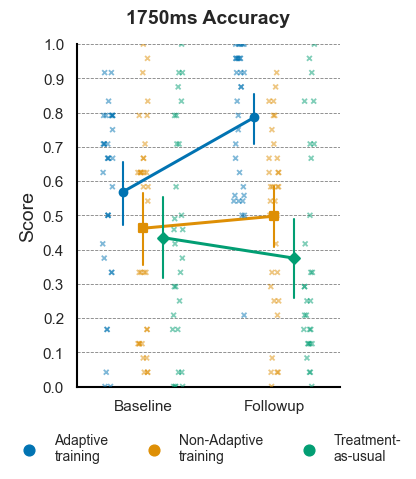

/Users/zhangtongyi/Vs_code/venv2_ml/lib/python3.10/site-packages/seaborn/categorical.py:1154: UserWarning: You passed a edgecolor/edgecolors ('#303030') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(cat_pos, strip_data, **kws)
/Users/zhangtongyi/Vs_code/venv2_ml/lib/python3.10/site-packages/seaborn/categorical.py:1154: UserWarning: You passed a edgecolor/edgecolors ('#303030') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(cat_pos, strip_data, **kws)
/Users/zhangtongyi/Vs_code/venv2_ml/lib/python3.10/site-packages/seaborn/categorical.py:1154: UserWarning: You passed a edgecolor/edgecolors ('#303030') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(cat_pos, strip_data, **kws)
/Users/zha

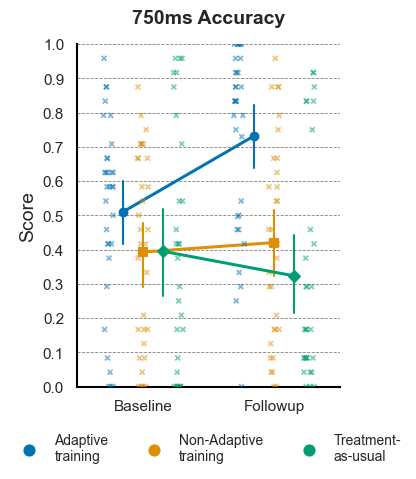

/Users/zhangtongyi/Vs_code/venv2_ml/lib/python3.10/site-packages/seaborn/categorical.py:1154: UserWarning: You passed a edgecolor/edgecolors ('#303030') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(cat_pos, strip_data, **kws)
/Users/zhangtongyi/Vs_code/venv2_ml/lib/python3.10/site-packages/seaborn/categorical.py:1154: UserWarning: You passed a edgecolor/edgecolors ('#303030') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(cat_pos, strip_data, **kws)
/Users/zhangtongyi/Vs_code/venv2_ml/lib/python3.10/site-packages/seaborn/categorical.py:1154: UserWarning: You passed a edgecolor/edgecolors ('#303030') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(cat_pos, strip_data, **kws)
/Users/zha

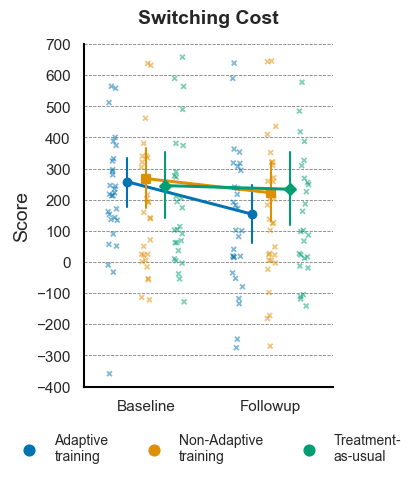

/Users/zhangtongyi/Vs_code/venv2_ml/lib/python3.10/site-packages/seaborn/categorical.py:1154: UserWarning: You passed a edgecolor/edgecolors ('#303030') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(cat_pos, strip_data, **kws)
/Users/zhangtongyi/Vs_code/venv2_ml/lib/python3.10/site-packages/seaborn/categorical.py:1154: UserWarning: You passed a edgecolor/edgecolors ('#303030') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(cat_pos, strip_data, **kws)
/Users/zhangtongyi/Vs_code/venv2_ml/lib/python3.10/site-packages/seaborn/categorical.py:1154: UserWarning: You passed a edgecolor/edgecolors ('#303030') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(cat_pos, strip_data, **kws)
/Users/zha

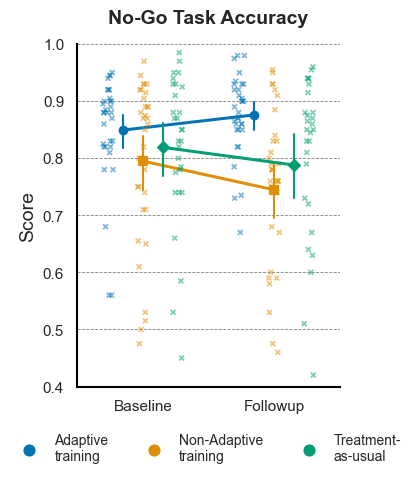

Interaction plots generated using original data!


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 读取 Excel 文件
file_name = 'processed_data.xlsx'
data = pd.read_excel(file_name)

# EF 前测和后测变量
ef_variables = [
    "Incongruent",
    "Interference_Effect", "Forward_Span", 
    "Backward_Span", "1750ms", "750ms", 
    "Switching_Cost", "NoGo_Accuracy"
]

# 自定义标题
custom_titles = {
    "Incongruent": "Incongruent Reaction Time",
    "Interference_Effect": "Interference Effect",
    "Forward_Span": "Forward Memory Span",
    "Backward_Span": "Backward Memory Span",
    "1750ms": "1750ms Accuracy",
    "750ms": "750ms Accuracy",
    "Switching_Cost": "Switching Cost",
    "NoGo_Accuracy": "No-Go Task Accuracy"
}

# 自定义 Y 轴范围和刻度
y_axis_settings = {
    "Incongruent": (350, 1200, 100),  # (min, max, step)
    "Interference_Effect": (-400, 180, 50),
    "Forward_Span": (0, 13, 1),
    "Backward_Span": (0, 11, 1),
    "1750ms": (0.0, 1.0, 0.1),
    "750ms": (0.0, 1.0, 0.1),
    "Switching_Cost": (-400, 700, 100),
    "NoGo_Accuracy": (0.4, 1.0, 0.1)
}

# 转为长格式数据
long_data = pd.melt(
    data,
    id_vars=["ID ", "Group", "Age", "Olanzapine_Equivalent", "Education_Years", "Gender"],
    value_vars=[f"{var}_Pretest" for var in ef_variables] + [f"{var}_Posttest" for var in ef_variables],
    var_name="Measurement",
    value_name="Score"
)

# 提取时间（Baseline/Followup）和 EF 变量名
long_data["Time"] = long_data["Measurement"].apply(lambda x: "Baseline" if "Pretest" in x else "Followup")
long_data["EF_Variable"] = long_data["Measurement"].str.replace("_Pretest", "").str.replace("_Posttest", "")

# 修改组别映射
group_labels = {
    1: "Adaptive \ntraining",
    2: "Non-Adaptive \ntraining",
    3: "Treatment-\nas-usual"
}

# 优化绘图参数
sns.set_theme(style="whitegrid", font="Arial", palette="colorblind")

# 绘制交互作用趋势图并叠加单个被试数据
for ef_var in ef_variables:
    original_data = long_data[long_data["EF_Variable"] == ef_var].copy()  # 使用原始数据作图
    
    # 更新组名
    original_data["Group"] = original_data["Group"].map(group_labels)
    
    plt.figure(figsize=(4, 5))
    
    # 叠加每个被试的数据点（使用原始数据）
    sns.stripplot(
        x="Time", y="Score", hue="Group", 
        data=original_data, dodge=True, jitter=0.12, 
        alpha=0.5, marker="x", size=3.5, linewidth=1.3, 
    )
    
    # 绘制趋势线（使用原始数据）
    sns.pointplot(
        x="Time", y="Score", hue="Group", 
        data=original_data, dodge=0.3, join=True, 
        markers=["o", "s", "D"], scale=0.8, ci=95, errwidth=1.5, linewidth=1.2
    )
    
    # 删除下划线，设置标题
    custom_title = custom_titles[ef_var]  # 使用自定义标题
    plt.title(custom_title, fontsize=14, fontweight="bold", pad=15)
    plt.xlabel("")  # 删除 X 轴标题
    plt.ylabel("Score", fontsize=14)
    
    # 设置图例样式和位置
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(
        handles[:3], labels[:3],  # 仅显示一次图例
        title_fontsize=12, fontsize=10, 
        loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=3, frameon=False
    )

    # 自定义 Y 轴范围和刻度
    y_min, y_max, y_step = y_axis_settings[ef_var]
    ax = plt.gca()
    ax.set_ylim(y_min, y_max)
    ax.set_yticks(np.arange(y_min, y_max + y_step, y_step))
    
    # 优化网格线：仅保留水平主网格
    ax.grid(True, axis="y", color="gray", linestyle="--", linewidth=0.6)
    ax.grid(False, axis="x")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    
    # 加粗外边框并设置颜色为黑色
    for spine in ax.spines.values():
        spine.set_linewidth(1.5)
        spine.set_color("black")
    
    plt.tight_layout()
    plt.savefig(f"./image/{ef_var}_trend_original_data.jpg", dpi=1200, bbox_inches="tight")
    plt.show()

print("Interaction plots generated using original data!")

In [25]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.multicomp import MultiComparison
import warnings

warnings.filterwarnings('ignore')

# 读取数据
file_name = 'processed_data.xlsx'
data = pd.read_excel(file_name)

# 定义 PANSS 基线和随访变量
panss_variables = [
    "PANSS_Positive",
    "PANSS_Negative",
    "PANSS_G",
    "PANSS_T"
]

# 控制变量
control_variables = ["Age", "Olanzapine_Equivalent", "Education_Years", "Gender"]

# 添加 Subject 列（用于 LMM 分析的随机效应）
data['Subject'] = data.index
data = data.reset_index(drop=True)

# 确保所需列存在
required_columns = ["Group", "Subject"] + [
    f"{var}_Baseline" for var in panss_variables
] + [
    f"{var}_Followup" for var in panss_variables
] + control_variables

missing_columns = [col for col in required_columns if col not in data.columns]
if missing_columns:
    raise KeyError(f"The following required columns are missing from the data: {missing_columns}")

# 创建字典以存储结果
results = {}

# 对每个变量进行线性混合效应模型分析
def perform_lmm_analysis(panss_var):
    # 数据重塑为长格式
    df_long = pd.melt(
        data,
        id_vars=["Group", "Subject"] + control_variables,
        value_vars=[f"{panss_var}_Baseline", f"{panss_var}_Followup"],
        var_name='Time', value_name='Score'
    )
    
    df_long['Time'] = df_long['Time'].map({f"{panss_var}_Baseline": 0, f"{panss_var}_Followup": 1})
    df_long['Group'] = df_long['Group'].astype('category')
    
    # 哑变量生成
    df_long = pd.get_dummies(df_long, columns=['Gender'], drop_first=True)

    # 定义线性混合效应模型公式
    formula = ("Score ~ Time * Group + Age + Olanzapine_Equivalent + "
               "Education_Years + " +
               " + ".join(df_long.columns[df_long.columns.str.startswith(('Gender_'))]))
    
    md = mixedlm(formula, df_long, groups=df_long["Subject"], re_formula="~Time")
    mdf = md.fit()
    
    # 提取固定效应的 p 值
    p_values = mdf.pvalues.loc[['Time', 'Group[T.2]', 'Group[T.3]', 'Time:Group[T.2]', 'Time:Group[T.3]']]
    
    # 多重比较校正
    _, p_values_corrected, _, _ = multipletests(p_values, method='fdr_bh', is_sorted=False)
    p_values_corrected_dict = dict(zip(p_values.index, p_values_corrected))

    # 存储结果
    return {
        'LMM_summary': mdf.summary(),
        'p_values': p_values,
        'p_values_corrected': p_values_corrected_dict,
        'df_long': df_long  # Store the long format data for post-hoc analysis
    }

# 对每个变量进行分析并存储结果
for panss_var in panss_variables:
    results[panss_var] = perform_lmm_analysis(panss_var)

# 输出结果
for panss_var, result in results.items():
    print(f"\n--- Results for {panss_var} ---")
    print(result['LMM_summary'])
    
    # 显示校正后的显著性结果
    print("\nCorrected p-values:")
    for term, corrected_p in result['p_values_corrected'].items():
        print(f"{term}: {corrected_p:.3f}")

    # 进行事后比较（显著交互作用）
    interaction_terms = ['Time:Group[T.2]', 'Time:Group[T.3]']
    if any(result['p_values_corrected'][term] < 0.1 for term in interaction_terms):  # 检查显著交互作用
        print("\nSignificant interaction detected. Performing post-hoc analysis...")
        
        mc = MultiComparison(result['df_long']['Score'], 
                             result['df_long']['Time'].astype(str) + "_" + result['df_long']['Group'].astype(str))
        post_hoc_results = mc.tukeyhsd(alpha=0.05)
        
        # 输出 Tukey HSD 结果
        print("\n--- Tukey HSD Post-Hoc Results ---")
        summary_df = pd.DataFrame(data=post_hoc_results.summary().data[1:], columns=post_hoc_results.summary().data[0])
        print(summary_df)

        # 输出均值和标准差
        means = result['df_long'].groupby(['Time', 'Group'])['Score'].agg(['mean', 'std']).reset_index()
        means['Group'] = means['Group'].map({1: 'Group 1', 2: 'Group 2', 3: 'Group 3'})
        means['Time'] = means['Time'].map({0: 'Baseline', 1: 'Followup'})
        
        print("\n--- Means and Standard Deviations ---")
        print(means)


--- Results for PANSS_Positive ---
              Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    Score    
No. Observations:      188        Method:                REML     
No. Groups:            94         Scale:                 8.7760   
Min. group size:       2          Log-Likelihood:        -549.8222
Max. group size:       2          Converged:             Yes      
Mean group size:       2.0                                        
------------------------------------------------------------------
                       Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
------------------------------------------------------------------
Intercept              16.777    2.209  7.596 0.000  12.448 21.105
Group[T.2]              2.011    1.669  1.205 0.228  -1.261  5.283
Group[T.3]              0.178    1.724  0.103 0.918  -3.202  3.557
Time                   -9.469    1.175 -8.056 0.000 -11.772 -7.165
Time:Group[T.2]         1.378    1.650  0

/Users/zhangtongyi/Vs_code/venv2_ml/lib/python3.10/site-packages/seaborn/categorical.py:1154: UserWarning: You passed a edgecolor/edgecolors ('#303030') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(cat_pos, strip_data, **kws)
/Users/zhangtongyi/Vs_code/venv2_ml/lib/python3.10/site-packages/seaborn/categorical.py:1154: UserWarning: You passed a edgecolor/edgecolors ('#303030') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(cat_pos, strip_data, **kws)
/Users/zhangtongyi/Vs_code/venv2_ml/lib/python3.10/site-packages/seaborn/categorical.py:1154: UserWarning: You passed a edgecolor/edgecolors ('#303030') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(cat_pos, strip_data, **kws)
/Users/zha

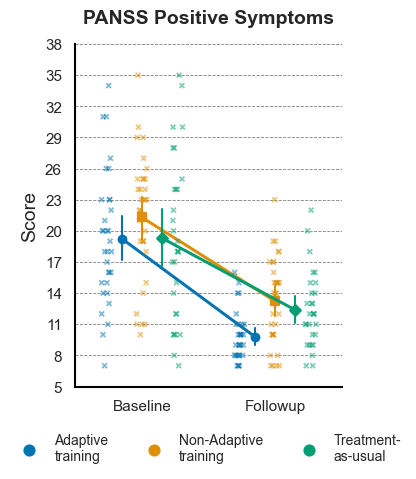

/Users/zhangtongyi/Vs_code/venv2_ml/lib/python3.10/site-packages/seaborn/categorical.py:1154: UserWarning: You passed a edgecolor/edgecolors ('#303030') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(cat_pos, strip_data, **kws)
/Users/zhangtongyi/Vs_code/venv2_ml/lib/python3.10/site-packages/seaborn/categorical.py:1154: UserWarning: You passed a edgecolor/edgecolors ('#303030') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(cat_pos, strip_data, **kws)
/Users/zhangtongyi/Vs_code/venv2_ml/lib/python3.10/site-packages/seaborn/categorical.py:1154: UserWarning: You passed a edgecolor/edgecolors ('#303030') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(cat_pos, strip_data, **kws)
/Users/zha

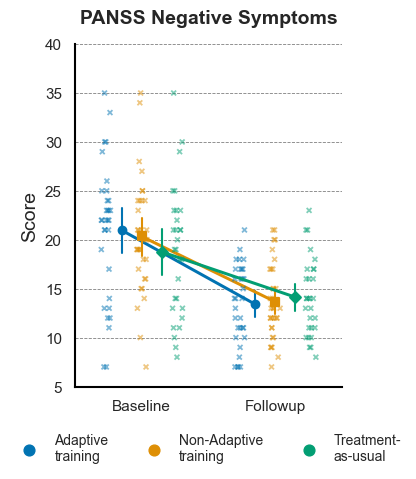

/Users/zhangtongyi/Vs_code/venv2_ml/lib/python3.10/site-packages/seaborn/categorical.py:1154: UserWarning: You passed a edgecolor/edgecolors ('#303030') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(cat_pos, strip_data, **kws)
/Users/zhangtongyi/Vs_code/venv2_ml/lib/python3.10/site-packages/seaborn/categorical.py:1154: UserWarning: You passed a edgecolor/edgecolors ('#303030') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(cat_pos, strip_data, **kws)
/Users/zhangtongyi/Vs_code/venv2_ml/lib/python3.10/site-packages/seaborn/categorical.py:1154: UserWarning: You passed a edgecolor/edgecolors ('#303030') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(cat_pos, strip_data, **kws)
/Users/zha

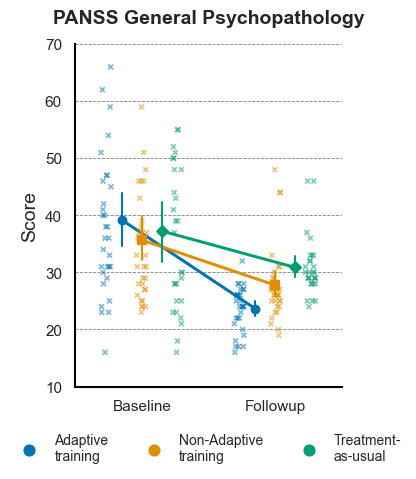

/Users/zhangtongyi/Vs_code/venv2_ml/lib/python3.10/site-packages/seaborn/categorical.py:1154: UserWarning: You passed a edgecolor/edgecolors ('#303030') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(cat_pos, strip_data, **kws)
/Users/zhangtongyi/Vs_code/venv2_ml/lib/python3.10/site-packages/seaborn/categorical.py:1154: UserWarning: You passed a edgecolor/edgecolors ('#303030') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(cat_pos, strip_data, **kws)
/Users/zhangtongyi/Vs_code/venv2_ml/lib/python3.10/site-packages/seaborn/categorical.py:1154: UserWarning: You passed a edgecolor/edgecolors ('#303030') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(cat_pos, strip_data, **kws)
/Users/zha

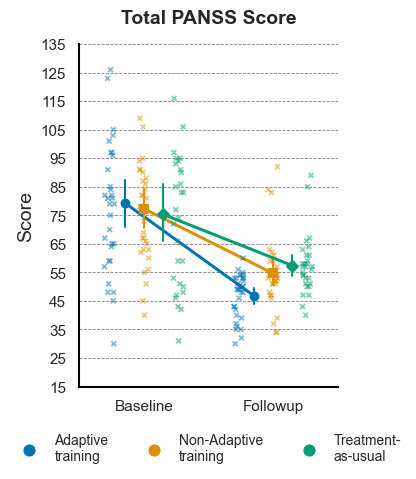

Interaction plots generated using original data!


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 读取 Excel 文件
file_name = 'processed_data.xlsx'
data = pd.read_excel(file_name)

# PANSS 基线和随访变量
panss_variables = [
    "PANSS_Positive",
    "PANSS_Negative",
    "PANSS_G",
    "PANSS_T"
]

# 自定义标题
custom_titles = {
    "PANSS_Positive": "PANSS Positive Symptoms",
    "PANSS_Negative": "PANSS Negative Symptoms",
    "PANSS_G": "PANSS General Psychopathology",
    "PANSS_T": "Total PANSS Score"
}

# 自定义 Y 轴范围和刻度
y_axis_settings = {
    "PANSS_Positive": (5, 38, 3),  # (min, max, step)
    "PANSS_Negative": (5, 40, 5),
    "PANSS_G": (10, 70, 10),
    "PANSS_T": (15, 130, 10)
}

# 转为长格式数据
long_data = pd.melt(
    data,
    id_vars=["ID ", "Group", "Age", "Olanzapine_Equivalent", "Education_Years", "Gender"],
    value_vars=[f"{var}_Baseline" for var in panss_variables] + [f"{var}_Followup" for var in panss_variables],
    var_name="Measurement",
    value_name="Score"
)

# 提取时间（Baseline/Followup）和 PANSS 变量名
long_data["Time"] = long_data["Measurement"].apply(lambda x: "Baseline" if "Baseline" in x else "Followup")
long_data["PANSS_Variable"] = long_data["Measurement"].str.replace("_Baseline", "").str.replace("_Followup", "")


group_labels = {
    1: "Adaptive \ntraining",
    2: "Non-Adaptive \ntraining",
    3: "Treatment-\nas-usual"
}

# 优化绘图参数
sns.set_theme(style="whitegrid", font="Arial", palette="colorblind")

# 绘制交互作用趋势图并叠加单个被试数据
for panss_var in panss_variables:
    original_data = long_data[long_data["PANSS_Variable"] == panss_var].copy()  # 使用原始数据作图
    
    # 更新组名
    original_data["Group"] = original_data["Group"].map(group_labels)
    
    plt.figure(figsize=(4, 5))
    
    # 叠加每个被试的数据点（使用原始数据）
    sns.stripplot(
        x="Time", y="Score", hue="Group", 
        data=original_data, dodge=True, jitter=0.12, 
        alpha=0.5, marker="x", size=3.5, linewidth=1.3, 
    )
    
    # 绘制趋势线（使用原始数据）
    sns.pointplot(
        x="Time", y="Score", hue="Group", 
        data=original_data, dodge=0.3, join=True, 
        markers=["o", "s", "D"], scale=0.8, ci=95, errwidth=1.5, linewidth=1.2
    )
    
    # 删除下划线，设置标题
    custom_title = custom_titles[panss_var]  # 使用自定义标题
    plt.title(custom_title, fontsize=14, fontweight="bold", pad=15)
    plt.xlabel("")  # 删除 X 轴标题
    plt.ylabel("Score", fontsize=14)
    
    # 设置图例样式和位置
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(
        handles[:3], labels[:3],  # 仅显示一次图例
        title_fontsize=12, fontsize=10, 
        loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=3, frameon=False
    )

    # 自定义 Y 轴范围和刻度
    y_min, y_max, y_step = y_axis_settings[panss_var]
    ax = plt.gca()
    ax.set_ylim(y_min, y_max)
    ax.set_yticks(np.arange(y_min, y_max + y_step, y_step))
    
    # 优化网格线：仅保留水平主网格
    ax.grid(True, axis="y", color="gray", linestyle="--", linewidth=0.6)
    ax.grid(False, axis="x")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    
    # 加粗外边框并设置颜色为黑色
    for spine in ax.spines.values():
        spine.set_linewidth(1.5)
        spine.set_color("black")
    
    plt.tight_layout()
    plt.savefig(f"./image/{panss_var}_trend_original_data.jpg", dpi=1200, bbox_inches="tight")
    plt.show()

print("Interaction plots generated using original data!")

In [28]:
print('数据分析全部完成！')

数据分析全部完成！
